In [1]:
from netCDF4 import Dataset
from pprint import pprint
from scipy.signal import detrend
import pickle
import xarray as xr
from cartoplot import cartoplot
import itertools
import mask
from scipy.stats import pearsonr
from field_importer import get_field
import pandas as pd
from scipy.interpolate import NearestNDInterpolator
from collections import defaultdict
import scipy.interpolate
from field_importer import get_field
from scipy.stats import linregress
import warnings
from mask import select_region
from select_type import select_type
import numpy.ma as ma
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import trange
from regrid import regrid
import matplotlib.image as mpimg
%config Completer.use_jedi = False

dir_to_save = '/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper_v2'


def rea(my_list):
    
    """Moves the last bit of a list to the front - helps with winter months"""
    
    end = list(my_list)[4:] # Get last four
    beginning = list(my_list)[:4] # Get first three
    result = end+beginning # Put the last four before first three
    return(result)

def remove_infs(x,y):
    
    not_inf_array = ~ np.isinf(y)

    clean_x = np.array(x)[not_inf_array]
    clean_y = np.array(y)[not_inf_array]
    
    return(clean_x,clean_y)

def remove_nans(x,y):

    not_nan_array = ~ np.isnan(y) # Selecte elements of y that are not nan

    clean_x = np.array(x)[not_nan_array] # Select elements of x that correspond to valid y values
    clean_y = np.array(y)[not_nan_array] # Select valid y values
    
    return(clean_x,clean_y)
    

def nanregress(x,y,debug=False):
    
    """Carries out a regression with missing data"""
    
    clean_x, clean_y = remove_nans(x,y)
    
    clean_x, clean_y = remove_infs(clean_x,clean_y)
        
    stats = linregress(clean_x,clean_y) # Regress the valid x-y pairs
    
          
    if debug:
        print()
        print('Nanregress')
        print(list(zip(x,y)))
        print(list(zip(clean_x,clean_y)))
        print(stats)
        print()
    
    return(stats)

def detrender(x,y,debug=False):
    
    """Detrends data by using nanregress"""
    
    stats = nanregress(x,y,debug) # Generate a regression between x and y (pairs with nan values of y are removed)
    
    trend_y = [stats[0]*x_val + stats[1] for x_val in x] # Calculate the straight line value at the x coords
    
    detrended = list(np.subtract(y,trend_y)) # Subtract the straight line values at x coords
    
    return(detrended)

def get_component(dataset,year,month):
    
    
    """Gets the 'thickness' component froms snow or freeboard.
    Dataset keyword must be one of 'SM', 'mW99' or 'free'"""

    data_dir = '/home/robbie/Dropbox/SM_Thickness/data/Components/' # Specify location of thickness component data

    with xr.open_dataset(f'{data_dir}{year}_components.nc') as data: # Open component data for year with xarray

        ds_month = data.where(int(month) == data.month, drop=True) # Select the month of thickness component data

        return(np.array(ds_month[dataset])[0])
    
def denan_based_on_list(*args):
    
    """Takes two lists of corresponding variables and 
    removes pairs where one or both elements are np.nan"""
    
    # Replace these for loops with list comps, then document

    nans_to_pop = []
    for i in range(len(args[0])):
        for series in args:
            if np.isnan(series[i]) or np.isinf(series[i]):
                nans_to_pop.append(i)

    output_list = []

    for series in args:
        for index in sorted(list(dict.fromkeys(nans_to_pop)), reverse=True):
            del series[index]

    return(tuple(args))


/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [2]:
month_list = ["01","02","03","04","10","11","12"]

month_name_list_short = ["Oct","Nov","Dec","Jan", "Feb", "Mar", "Apr"]

month_name_list_full = ["October","November","December","January", "February", "March", "April"]

region_list = [ "Barents",
                "Kara",
                "Laptev",
                "East Siberian",
                "Chukchi",
                "Beaufort",
                "Marginals",
                "Central Arctic"]

full_snow_product_names = {'SM':'SnowModel-LG',
                               'NS':'NESOSIM'}

# Carry out a month-by-month, year-by-year analysis and output a dataframe

In [3]:
year_range = (2002,2018)

NS_start_year, NS_end_year = 2002, 2015

ice_types = ['MYI','FYI','all']

def analyse(adjust_envi=False):
    
    freeboard_code = 'free_adj' if adjust_envi else 'free'

    results = []
    
    for region, month in itertools.product(region_list, month_list):
        
        print(region,month)

        if region == "Central Arctic":
            yearlist = list(range(2010,year_range[1]+1))
        else:
            yearlist = list(range(year_range[0],year_range[1]+1))

        if int(month) > 7:
            yearlist = yearlist[:-1]
        else:
            yearlist = yearlist[1:]

        for year in yearlist:

            datapoint = {'month':month,
                         'year':year,
                         'region':region}

            with warnings.catch_warnings(): # This avoids incessant mean of empty slice warnings
                warnings.simplefilter("ignore", category=RuntimeWarning)
                
                for dataset in ['SM', 'E5', 'M2', 'NS', 'mW99', 'free']:
                    
                    if (dataset == 'NS') & ~(NS_start_year <= year <= NS_end_year):
                    
                        for ice_type in ice_types:
                        
                            datapoint[f'{ice_type} {dataset} contribution']   = np.nan
                            datapoint[f'{ice_type} {dataset} thickness']   = np.nan

                        
                    else:
                        
                        d_code = freeboard_code if dataset == 'free' else dataset
                        
                        contribution = get_component(d_code,year,month)

                        contribution = select_region(region,contribution)
                        
                        for ice_type in ice_types:
                            
                            type_contribution = select_type(ice_type, contribution, year, month)
                            datapoint[f'{ice_type} {dataset} contribution num']   = np.count_nonzero(~np.isnan(type_contribution))
                            datapoint[f'{ice_type} {dataset} contribution']   = np.nanmean(type_contribution)

                        if dataset != 'free':

                            # Add RF and Snow components to get thickness

                            thickness = contribution + get_component(freeboard_code,year,month)
                            
                            thickness = select_region(region, thickness)
                        
                            for ice_type in ice_types:
                                
                                type_thickness = select_type(ice_type, thickness, year, month)
                                datapoint[f'{ice_type} {dataset} thickness']   = np.nanmean(type_thickness)
                                datapoint[f'{ice_type} {dataset} thickness num']   = np.count_nonzero(~np.isnan(type_thickness))
                            
            results.append(datapoint)


            
    
    df = pd.DataFrame(results)
    
    return(df)

# beta_adj = analyse(adjust_envi=True)
# pickle.dump(beta_adj, open('beta_adj_frame.p','wb'))

# pickle.dump(beta, open('beta_frame.p','wb'))
beta = pickle.load(open('beta_frame.p','rb'))

# beta.head()

# beta = analyse(adjust_envi=False)



In [4]:
num_dict = {'month':beta['month'],
            'year':beta['year'],
            'region':beta['region']}

for col in beta.columns:
    if 'num' in col:
        num_dict[col] = beta[col]
        
        
df = pd.DataFrame(num_dict)

df

month  year          region  FYI SM contribution num  \
0      01  2003         Barents                      837   
1      01  2004         Barents                      978   
2      01  2005         Barents                      489   
3      01  2006         Barents                      199   
4      01  2007         Barents                      298   
..    ...   ...             ...                      ...   
835    12  2013  Central Arctic                     1428   
836    12  2014  Central Arctic                     1618   
837    12  2015  Central Arctic                     1062   
838    12  2016  Central Arctic                     1184   
839    12  2017  Central Arctic                     1025   

     MYI SM contribution num  all SM contribution num  FYI SM thickness num  \
0                        194                     1031                   540   
1                          0                      978                   841   
2                          0                      489                   295   
3                          8                      242                   116   
4                         12                      349                   200   
..                       ...                      ...                   ...   
835                     3306                     4808                  1410   
836                     3116                     4815                  1593   
837                     3635                     4740                  1026   
838                     3467                     4683                  1095   
839                     3694                     4759                   980   

     MYI SM thickness num  all SM thickness num  FYI E5 contribution num  ...  \
0                     192                   732                      837  ...   
1                       0                   841                      978  ...   
2                       0                   295                      489  ...   
3                       5                   138                      199  ...   
4                       0                   216                      298  ...   
..                    ...                   ...                      ...  ...   
835                  3158                  4585                     1428  ...   
836                  2988                  4618                     1618  ...   
837                  3472                  4501                     1062  ...   
838                  3318                  4417                     1184  ...   
839                  3530                  4520                     1025  ...   

     all NS thickness num  FYI mW99 contribution num  \
0                   672.0                        841   
1                   810.0                        983   
2                   250.0                        496   
3                    65.0                        200   
4                   177.0                        298   
..                    ...                        ...   
835                4555.0                       1428   
836                4610.0                       1618   
837                   0.0                       1062   
838                   NaN                       1185   
839                   NaN                       1025   

     MYI mW99 contribution num  all mW99 contribution num  \
0                          194                       1035   
1                            0                        983   
2                            0                        496   
3                            8                        208   
4                           12                        310   
..                         ...                        ...   
835                       3308                       4736   
836                       3118                       4750   
837                       3638                       4700   
838                       3469                       4656   
839              

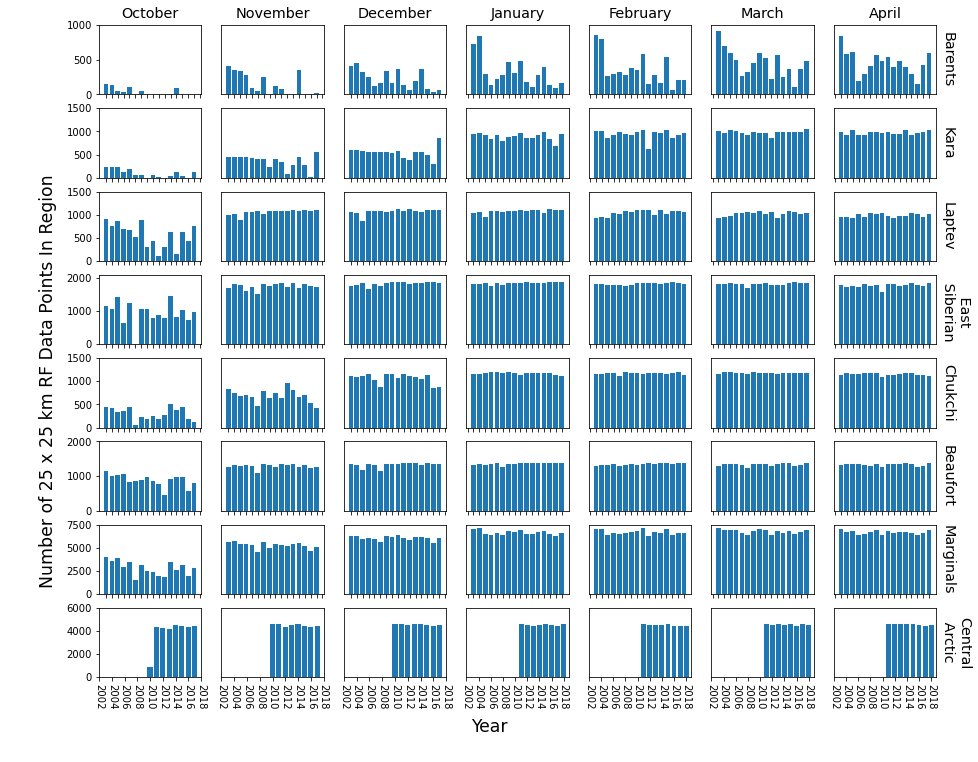

In [5]:
counter = 1
fig = plt.figure(figsize=(15,12))

ylims = {'Barents':1000,
         'Kara':1500,
         'Laptev':1500,
         'East Siberian':2100,
         'Chukchi':1500,
         'Beaufort':2000,
         'Marginals':7500,
         'Central Arctic':6000}

for region in region_list:
    for month in rea(month_list):
        
        rdf = df[(df['region'] == region) & (df['month'] == month)]
        
        
        ax = plt.subplot(len(region_list),len(month_list),counter)
        ax.bar(rdf['year'], rdf['all free contribution num'])
        
        if counter% 7 == 0:
            
            if region == 'Central Arctic':
                region_name = 'Central\n Arctic'
            elif region == 'East Siberian':
                region_name = '    East\n Siberian'
            else:
                region_name = region
            
            ax.annotate(region_name,xy = (1.05,0.5),
                              xycoords='axes fraction',
                              fontsize='x-large',
                              va='center',
                              ha='left',
                              rotation=270)
            
        ax.set_ylim(0,ylims[region])
        
            
        if counter < 8:

            ax.annotate(month_name_list_full[counter-1],
                              xy = (0.5,1.1),xycoords='axes fraction',
                              ha='center',fontsize="x-large")
            
        xticks = np.arange(2002,2019)
        if counter < len(month_list)*(len(region_list)-1)+1:
            ax.set_xticks(ticks=xticks)
            ax.set_xticklabels([])
        else:
            ax.set_xticks(xticks[::2])
            ax.set_xticklabels(xticks[::2])
            ax.tick_params('x',rotation = 270)
        
        if counter % 7 == 1:
            pass
        else:
            ax.set_yticks(ticks=[])

        
        counter +=1
        
plt.annotate(r"Number of 25 x 25 km RF Data Points In Region",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

plt.annotate(f"Year",
                 xy = (0.5,0.04),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')

plt.savefig(f"{dir_to_save}/Sup_Figs/num_points.png",dpi=450,bbox_inches='tight')
plt.show()

In [6]:
region = 'Barents'
month = '10'

rdf = df[(df['region'] == region) & (df['month'] == month)]

rdf[['year','all free contribution num']]

year  all free contribution num
64  2002                        155
65  2003                        143
66  2004                         43
67  2005                         39
68  2006                        107
69  2007                          2
70  2008                         53
71  2009                          0
72  2010                          0
73  2011                          1
74  2012                          0
75  2013                          0
76  2014                         93
77  2015                          0
78  2016                          0
79  2017                          0

# Plot correlations between RF and snow contributions (for SM and NS)

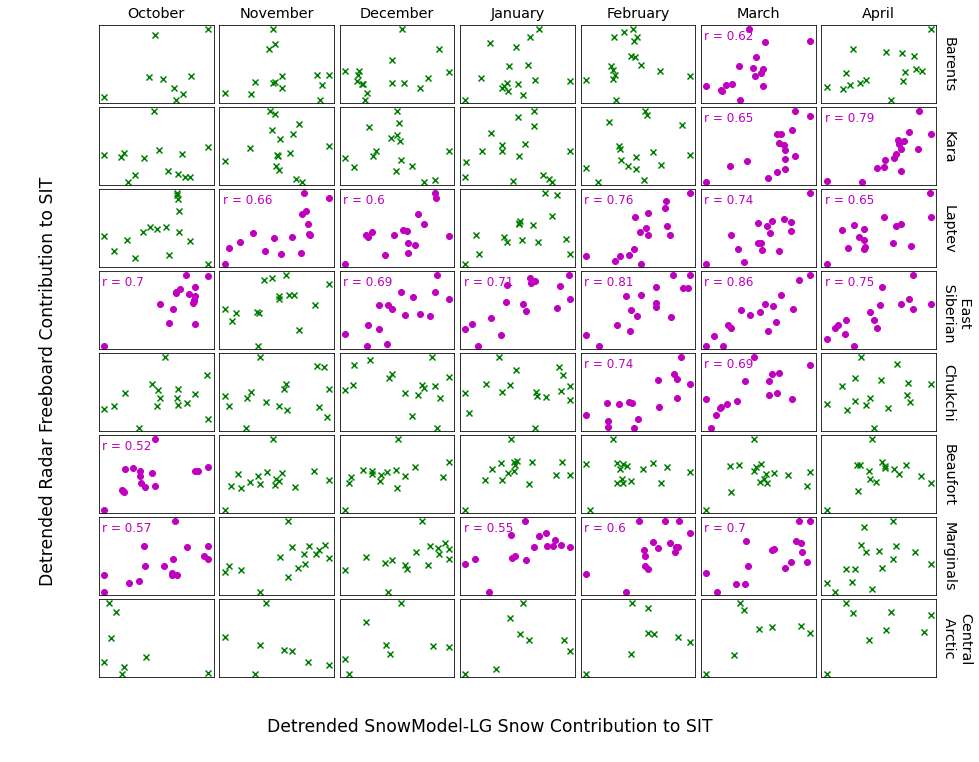

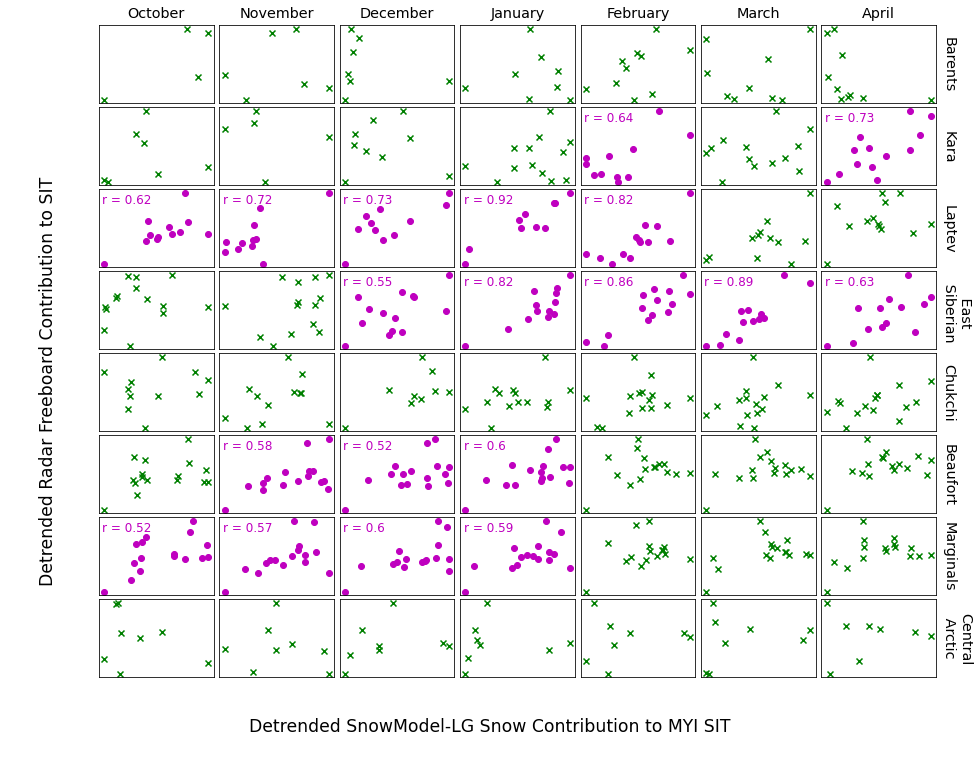

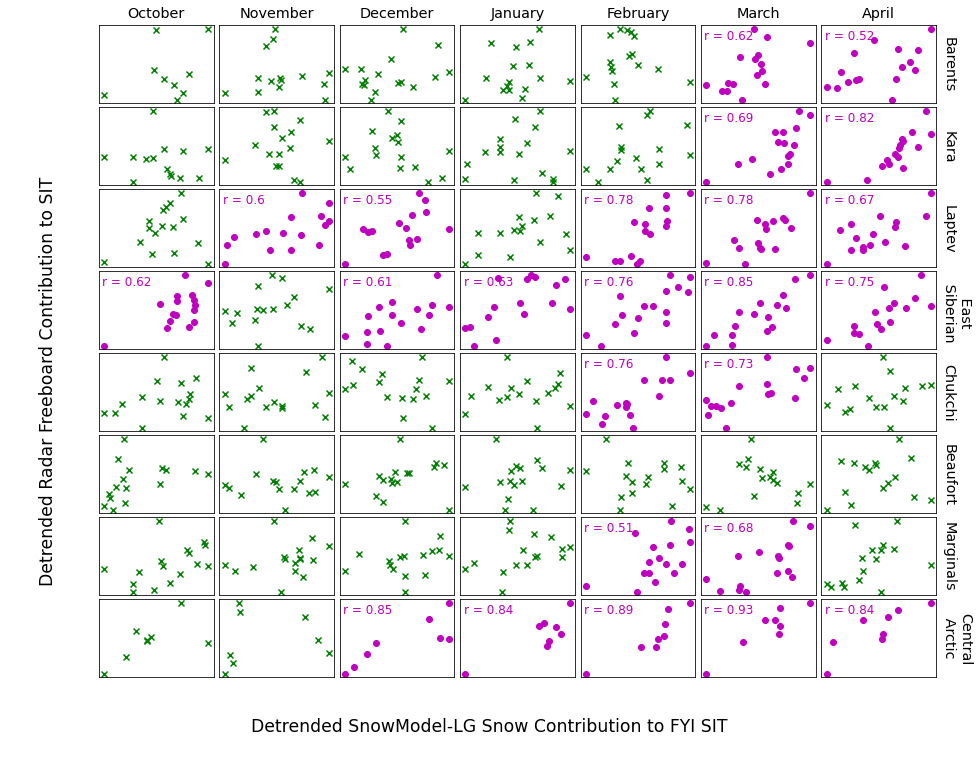

In [7]:
def plot_radar_snow_correlations(ice_type,snow_product,beta,fname=None):
    
    fig = plt.figure(figsize=(15,12))

    for subplot_counter, (region, month) in enumerate(itertools.product(region_list, rea(month_list)), 1):
        
        d = {}
        
        for var in ['free', snow_product]:
            
            # Subset the main dataframe by month and region

            subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
            
            series = list(subset[f'{ice_type} {var} contribution'])
            
            years  = list(subset['year'])

            detrended_series = detrender(years,series,debug=False)
            
            d[var] = detrended_series
    
        fb, SM = denan_based_on_list(d['free'], d[snow_product])
#         fb, SM = remove_nans(d['free'], d[snow_product])
#         SM, fb = remove_nans(SM, fb)
#         fb, SM = remove_infs(fb, SM)
        
        correlation = pearsonr(fb,SM)


        #######################################################################
        
        ax = plt.subplot(len(region_list),len(month_list),subplot_counter)

        if correlation[1]<0.05:
            markercolor='m'
            marker='o'
            ax.annotate("r = "+str(np.round(correlation[0],decimals=2)),
#                                   + '\np = ' + str(np.round(correlation[1],decimals=2)),
                              xy = (0.03,0.95),xycoords='axes fraction',
                              ha='left',va='top',fontsize="large",color='m')
        else:
            markercolor='g'
            marker='x'

#             if correlation[0] <0:
#                 print(region,month,correlation)

        ax.scatter(fb,SM,
                         marker=marker,label='SM',color=markercolor)

        if subplot_counter < 8:

            ax.annotate(month_name_list_full[subplot_counter-1],
                              xy = (0.5,1.1),xycoords='axes fraction',
                              ha='center',fontsize="x-large")

        if subplot_counter% 7 == 0:
            
            if region == 'Central Arctic':
                region_name = 'Central\n Arctic'
            elif region == 'East Siberian':
                region_name = '    East\n Siberian'
            else:
                region_name = region
            
            ax.annotate(region_name,xy = (1.05,0.5),
                              xycoords='axes fraction',
                              fontsize='x-large',
                              va='center',
                              ha='left',
                              rotation=270)

        ax.set_xticks([])
        ax.set_yticks([])


    plt.annotate("Detrended Radar Freeboard Contribution to SIT",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')
    
    ylabcode = {'all':'',
                 'MYI':' MYI',
                 'FYI':' FYI'}

    plt.annotate(f"Detrended {full_snow_product_names[snow_product]} Snow Contribution to{ylabcode[ice_type]} SIT",
                 xy = (0.5,0.04),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    if (ice_type == 'all') & (snow_product=='SM'):
        subdir = 'Figures'
    else:
        subdir = 'Sup_Figs'
    
    
    if fname: plt.savefig(f"{dir_to_save}/{subdir}/{full_snow_product_names[snow_product]}_{ice_type}_{fname}.png",dpi=450,bbox_inches='tight')

    plt.show()


for ice_type in ['all',
                 'MYI',
                 'FYI',
                ]:
    
    plot_radar_snow_correlations(ice_type,'SM',beta,fname='correlations')
    
# plot_radar_snow_correlations('all','NS',beta,fname='correlations')

# Process the large dataframe (mbm, yby) into one of trends in each month for each region

# Does not generate a plot

In [8]:
def correlate_radar_snow(ice_type,snow_product,beta):

    covariance_data = []

    yticks = [0,0.2,0.4,0.6,0.8,1,1.2]
    
    variables = ['free', snow_product, 'mW99']

    for region, month in itertools.product(region_list, rea(month_list)):
        
        d = {}
        
        for var in variables:
            
            # Subset the main dataframe by month and region

            subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
            
            series = list(subset[f'{ice_type} {var} contribution'])
            
            years  = list(subset['year'])
            
            detrended_series = detrender(years,series)
            
            d[var] = detrended_series

        fb, SM, mw = denan_based_on_list(d['free'], d[snow_product], d['mW99'])

        cov_matrix = np.cov(fb, SM)

        mw_cov_matrix = np.cov(fb,mw)


        results = {'region':region,
                   'month':month,
                   'freeboard_var':cov_matrix[0,0],

                   'snow_var':cov_matrix[1,1],
                   'covariance':cov_matrix[0,1],

                   'mw99_snow_var':mw_cov_matrix[1,1],
                   'mw99_cov_var':mw_cov_matrix[0,1]}

        covariance_data.append(results)
        
    
    df = pd.DataFrame(covariance_data)
    
    df['SIT_var_ind'] = df['freeboard_var'] + df['snow_var'] + df['covariance']
    df['SIT_var'] = df['SIT_var_ind'] + df['covariance']
    df['SIT_std_ind'] = np.sqrt(df['SIT_var_ind'])
    df['SIT_std'] = np.sqrt(df['SIT_var'])
    df['SIT_std_diff'] = df['SIT_std']-df['SIT_std_ind']
    
    return(df)



c = correlate_radar_snow('all', 'SM',beta)
c_NS = correlate_radar_snow('all', 'NS',beta)
c_E5 = correlate_radar_snow('all', 'E5',beta)
c_M2 = correlate_radar_snow('all', 'M2',beta)
# a = correlate_radar_snow('FYI', 'SM')
# b = correlate_radar_snow('MYI', 'SM')



# Contributions to total IAV

SnowModel-LG:


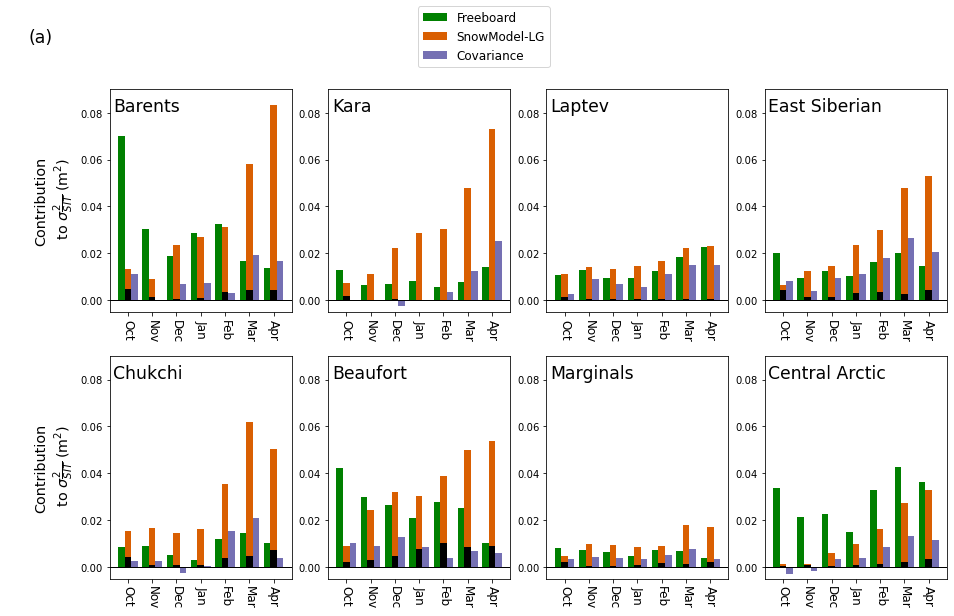

Nesosim:


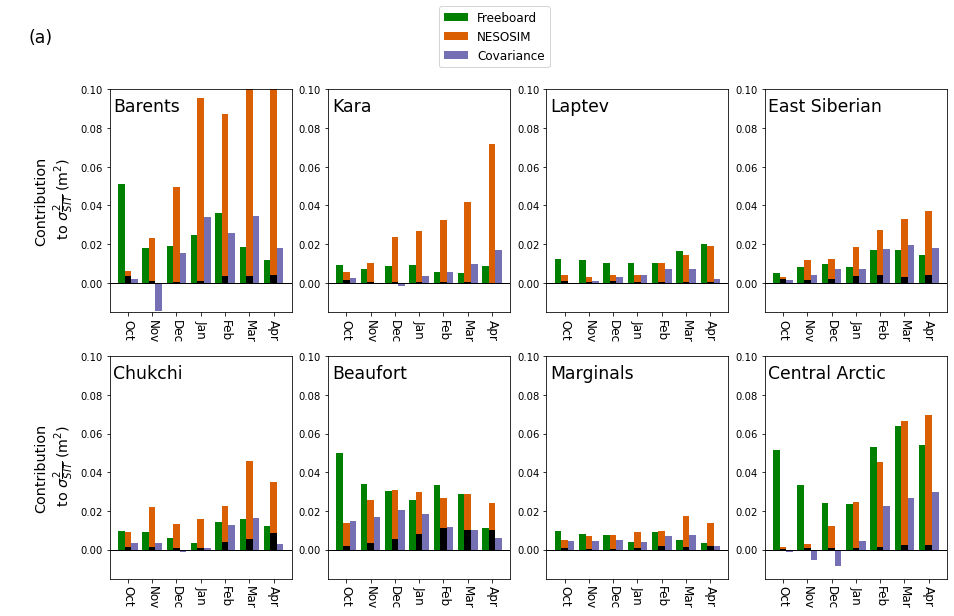

In [9]:
def abs_var_bar(c,snow_code):

    fig = plt.figure(figsize=(15,9))

    for subplot_counter, region in enumerate(region_list, 1):

        subset = c[c['region'] == region]

        fb_var = subset['freeboard_var']
        sm_var = subset['snow_var']
        covar = subset['covariance']

        mw_var = subset['mw99_snow_var']
        mw_covar = subset['mw99_cov_var']


        x = np.array(range(len(fb_var)))

        ax = plt.subplot(2,4,subplot_counter)

        bw = 0.27

        ax.bar(x-bw, fb_var, width=bw, color='green', align='center',label='Freeboard')
        ax.bar(x, sm_var, width=bw, color='#d95f02', align='center',label=f'{full_snow_product_names[snow_code]}')
        ax.bar(x, mw_var, width=bw, fc='k', align='center') 
        ax.bar(x+bw, covar, width=bw, color = '#7570b3', align = 'center', label = 'Covariance')
        ax.set_xticks([0,1,2,3,4,5,6])
        ax.set_xticklabels(month_name_list_short,
                        fontsize='large',rotation=270)
        
        legend_box = 2
        if subplot_counter == legend_box:
            ax.legend(fontsize='large',bbox_to_anchor=(1.25,1.4))

        ax.annotate(region,xy = (0.02,0.9),xycoords='axes fraction',fontsize='xx-large')
        ax.axhline(y=0, color='k', linewidth = 1)
        
        if snow_code == 'SM':
            ax.set_ylim(-0.005,0.09)
        elif snow_code == 'NS':
            ax.set_ylim(-0.015,0.1)

        if subplot_counter in [1,5]:
            
            sig_str = r'$\sigma^2_{\overline{SIT}}$'
            ax.set_ylabel(f'Contribution\n to {sig_str} (m$^2$)', fontsize = 'x-large')


    #     if subplot_counter > 4:
    #         ax.set_xlabel('Month', fontsize = 'x-large')

    
    plt.annotate("(a)",
                 xy = (0.03,0.93),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='left')
    
    sub_dir = 'Figures' if snow_code == 'SM' else 'Sup_Figs'
    
    fig.savefig(f'{dir_to_save}/{sub_dir}/abs_var_breakdown_{snow_code}.png',
                dpi=450, bbox_inches='tight')

    plt.show()

print('SnowModel-LG:')
abs_var_bar(c,'SM')
print('Nesosim:')
abs_var_bar(c_NS,'NS')

SnowModel-LG:
SM: Barents
0    11.647862
1    -1.654345
2    13.691223
3    11.537992
4     4.638753
5    20.525157
6    14.540683
Name: covariance, dtype: float64 0    14.055327
1    23.095726
2    48.071549
3    42.903156
4    46.668410
5    61.825445
6    73.358556
Name: snow_var, dtype: float64 0    74.296810
1    78.558619
2    38.237228
3    45.558851
4    48.692837
5    17.649398
6    12.100761
Name: freeboard_var, dtype: float64
SM: Kara
7     -2.645302
8     -2.526977
9     -9.468366
10     0.236668
11     8.873063
12    18.444666
13    22.444798
Name: covariance, dtype: float64 7     37.358875
8     65.626735
9     83.303229
10    77.562877
11    76.895690
12    70.241025
13    65.081233
Name: snow_var, dtype: float64 7     65.286427
8     36.900242
9     26.165137
10    22.200456
11    14.231247
12    11.314309
13    12.473970
Name: freeboard_var, dtype: float64
SM: Laptev
14    10.864452
15    24.787882
16    22.688027
17    18.398688
18    27.322039
19    26.884134
20    2

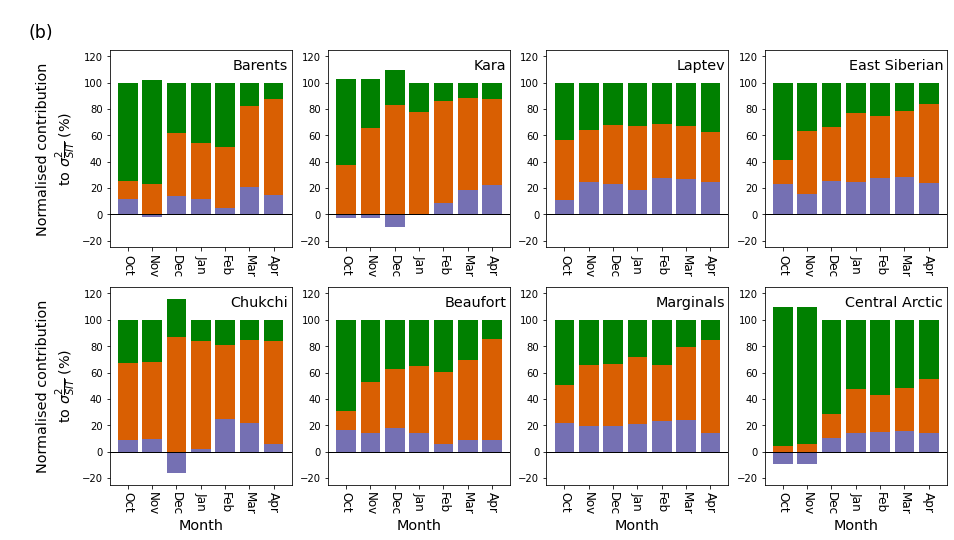

Nesosim:


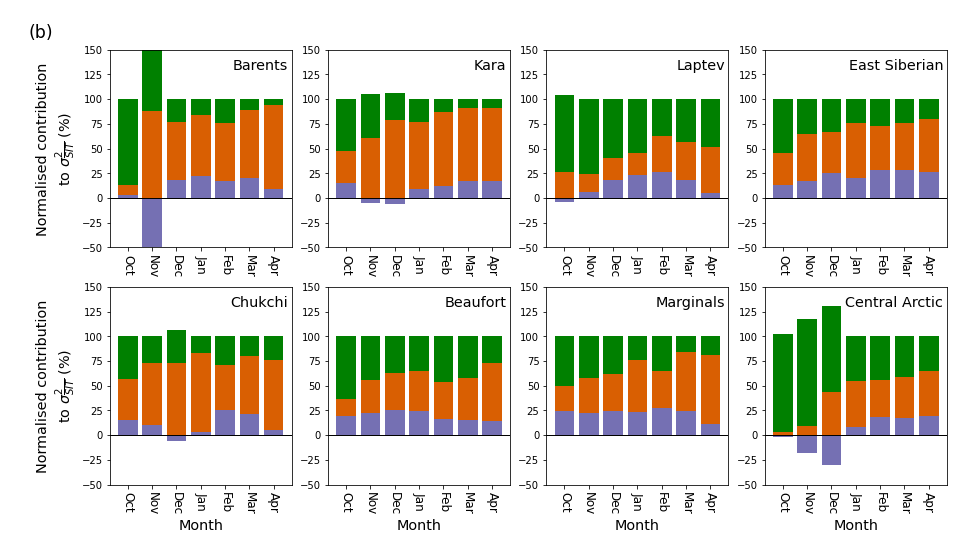

In [10]:
def rel_var_bar(c, snow_code, printer=False):

    fig = plt.figure(figsize=(15,8))

    for subplot_counter, region in enumerate(region_list, 1):

        subset = c[c['region'] == region]

        fb_var = subset['freeboard_var']
        sm_var = subset['snow_var']
        covar = subset['covariance']

        mw_var = subset['mw99_snow_var']
        mw_covar = subset['mw99_cov_var']


        x = np.array(range(len(fb_var)))

        ax = plt.subplot(2,4,subplot_counter)

        totals = np.array(fb_var) + np.array(sm_var) + np.array(covar)

        fb_var_norm = np.divide(fb_var,totals)*100
        covar_norm = np.divide(covar,totals)*100
        sm_var_norm = np.divide(sm_var,totals)*100

        covar_top = [x if x > 0 else 0 for x in covar_norm]

        # Fill between 0 and covar norm
        
        if printer:
            print(f'{snow_code}: {region}')
            print(covar_norm, sm_var_norm,fb_var_norm)
        

        ax.bar(x, covar_norm, color = '#7570b3',  label = 'Covariance')

        ax.bar(x,sm_var_norm, bottom = covar_top, color='#d95f02',label='SnowModel-LG')

        ax.bar(x, fb_var_norm, bottom = covar_top + sm_var_norm, color='green',label='Freeboard')
        
        


        ax.set_xticks([0,1,2,3,4,5,6])
        ax.set_xticklabels(month_name_list_short,
                        fontsize='large',rotation=270)

        ax.annotate(region,xy = (0.98,0.9),xycoords='axes fraction',fontsize='x-large',ha='right')
        ax.axhline(y=0, color='k', linewidth = 1)
        
        if snow_code == 'SM':
            ax.set_ylim(-25,125)
        else:
            ax.set_ylim(-50, 150)

        if subplot_counter in [1,5]:
            
            sig_str = r'$\sigma^2_{\overline{SIT}}$'
            ax.set_ylabel(f'Normalised contribution\nto {sig_str} (%)', fontsize = 'x-large')
#             ax.set_ylabel('Fraction of Total \nVariance (%)', fontsize = 'x-large')

        if subplot_counter > 4:
            ax.set_xlabel('Month', fontsize = 'x-large')
            
    plt.annotate("(b)",
                     xy = (0.03,0.93),
                     xycoords="figure fraction",
                     fontsize="xx-large",
                     ha='left')


    sub_dir = 'Figures' if snow_code == 'SM' else 'Sup_Figs'

    fig.savefig(f'{dir_to_save}/{sub_dir}/rel_var_breakdown_{snow_code}.png',
                dpi=450, bbox_inches='tight')


    str_to_pass = f'convert {dir_to_save}/{sub_dir}/abs_var_breakdown_{snow_code}.png {dir_to_save}/{sub_dir}/rel_var_breakdown_{snow_code}.png -append {dir_to_save}/{sub_dir}/var_contribs_{snow_code}.png'
    !{str_to_pass}

    plt.show()
    
print('SnowModel-LG:')
rel_var_bar(c, 'SM',printer=True)
print('Nesosim:')
rel_var_bar(c_NS, 'NS')

all
Region: Barents, Month: 12, SM: -0.04%, mW99: -0.018%
Region: Barents, Month: 01, SM: -0.04%, mW99: -0.017%
Region: Barents, Month: 03, SM: -0.054%, mW99: -0.022%
Region: Barents, Month: 04, SM: -0.043%, mW99: -0.027%
Region: Kara, Month: 10, SM: -0.079%, mW99: -0.049%
Region: Kara, Month: 11, SM: -0.087%, mW99: -0.063%
Region: Kara, Month: 12, SM: -0.068%, mW99: -0.048%
Region: Kara, Month: 01, SM: -0.052%, mW99: -0.038%
Region: Kara, Month: 02, SM: -0.04%, mW99: -0.025%
Region: Kara, Month: 03, SM: -0.035%, mW99: -0.019%
Region: Kara, Month: 04, SM: -0.032%, mW99: -0.026%
Region: Laptev, Month: 10, SM: -0.057%, mW99: -0.034%
Region: Laptev, Month: 11, SM: -0.064%, mW99: -0.04%
Region: Laptev, Month: 12, SM: -0.048%, mW99: -0.027%
Region: Laptev, Month: 01, SM: -0.036%, mW99: -0.018%
Region: Laptev, Month: 02, SM: -0.029%, mW99: -0.015%
Region: Laptev, Month: 03, SM: -0.023%, mW99: -0.016%
Region: Laptev, Month: 04, SM: -0.025%, mW99: -0.019%
Region: East Siberian, Month: 11, SM: 

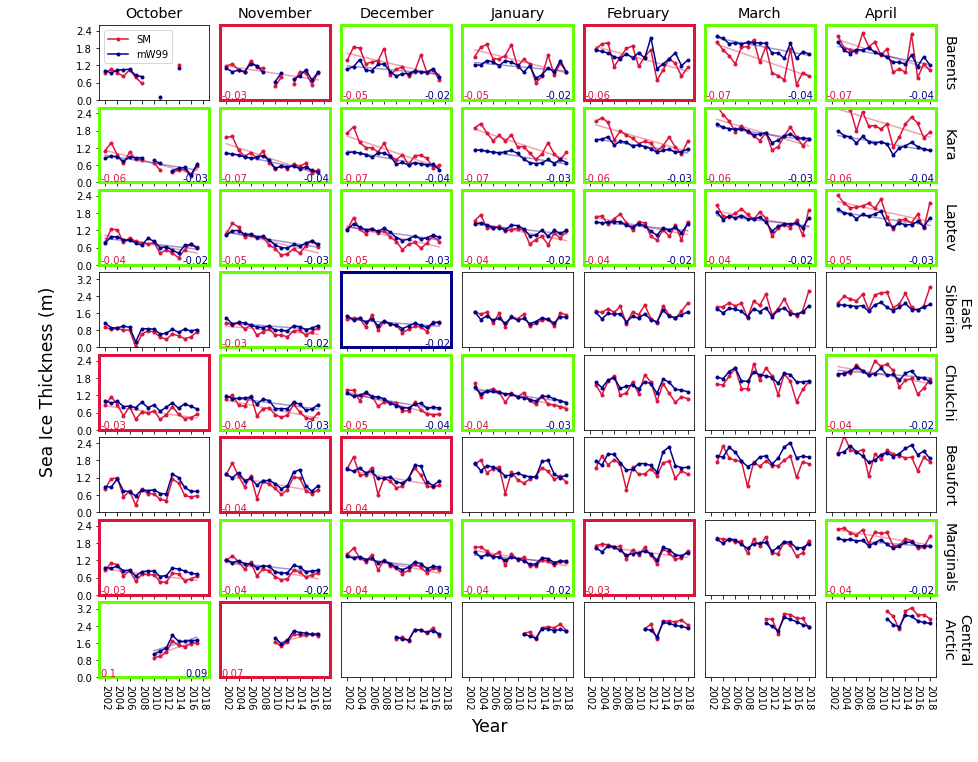

In [11]:
# monthlist = ['10', '11', '12', '01', '02', '03', '04']

def filter_df(df,start_year,end_year):
    
    df = df[(start_year <= df['year']) & (df['year'] <= end_year)]
    
    return(df)

def timeseries(ice_type,snow_product,snow_product_2, beta, print_statistics=None):
    
    significance_increase = []
    
    trends_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    
    print(ice_type)

    fig = plt.figure(figsize=(15,12))
    
    for subplot_counter, (region, month) in enumerate(itertools.product(region_list,rea(month_list)),1):

        ax = plt.subplot(len(region_list),len(month_list),subplot_counter)

        subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        
        if 'NS' in [snow_product, snow_product_2]:
            
            if int(month) > 7: subset = filter_df(subset,2002,2014)
            else: subset = filter_df(subset,2002,2015)
                

        W99 = list(subset[f'{ice_type} {snow_product_2} thickness'])
            
        SM = list(subset[f'{ice_type} {snow_product} thickness'])

        yearlist = list(subset['year'])

        # Calculate statistics
        SM_stats = nanregress(yearlist,SM)
        SM_mean = np.nanmean(SM)
        W99_stats = nanregress(yearlist,W99)
        W99_mean = np.nanmean(W99)
        
        SM_detrended = detrender(yearlist,SM)
        W99_detrended = detrender(yearlist,W99)
        
        SM_std = np.nanstd(SM_detrended)
        W99_std = np.nanstd(W99_detrended)
        
        if (SM_stats[3] < 0.05) and (W99_stats[3] < 0.05):

            trends_dict[region][month] = (SM_stats[0],W99_stats[0],SM_std,W99_std,SM_mean,W99_mean)

            # Shade if SM & W99 -> Green Solid Outline
            
#             print(f'Region: {region}, Month: {month}, SM: {np.round(SM_stats[0], decimals = 3)}, mW: {np.round(W99_stats[0], decimals = 3)} Frac: {np.round((SM_stats[0]/W99_stats[0])/W99_stats[0], decimals = 3)}')
            
            if print_statistics: print(f'Region: {region}, Month: {month}, SM: {np.round(SM_stats[0]/SM_mean, decimals = 3)}%, {snow_product_2}: {np.round(W99_stats[0]/W99_mean, decimals = 3)}%')
            
            
            
            for spine in ax.spines.values():
                spine.set_edgecolor('#66ff00')
                spine.set_linewidth('3')
                
            ax.plot(yearlist, np.array(yearlist)*SM_stats[0] + SM_stats[1], color='crimson', alpha=0.4)
            ax.plot(yearlist, np.array(yearlist)*W99_stats[0] + W99_stats[1], color='darkblue', alpha=0.4)
   
            ax.annotate(np.round(SM_stats[0], decimals = 2), xy = (0.01,0.02), xycoords = 'axes fraction',color='crimson')
            ax.annotate(np.round(W99_stats[0], decimals = 2), xy = (0.99,0.02), xycoords = 'axes fraction',color='darkblue', ha='right')



        elif (SM_stats[3] < 0.05):
            
            ax.plot(yearlist, np.array(yearlist)*SM_stats[0] + SM_stats[1], color='crimson', alpha=0.4)

            trends_dict[region][month] = (SM_stats[0],np.nan, SM_std, W99_std,SM_mean,W99_mean)

            # If only SM significant -> Crimson Solid outline
            
            ax.annotate(np.round(SM_stats[0], decimals = 2), xy = (0.01,0.02), xycoords = 'axes fraction',color='crimson')


            for spine in ax.spines.values():
                spine.set_edgecolor('crimson')
                spine.set_linewidth('3')

        elif (W99_stats[3] < 0.05):
            
            ax.plot(yearlist, np.array(yearlist)*W99_stats[0] + W99_stats[1], color='darkblue', alpha=0.4)
            ax.annotate(np.round(W99_stats[0], decimals = 2), xy = (0.99,0.02), xycoords = 'axes fraction',color='darkblue', ha='right')


            trends_dict[region][month] = (np.nan ,W99_stats[0], SM_std, W99_std,SM_mean,W99_mean)

            # If only W99 significant -> Darkblue Solid outline

            for spine in ax.spines.values():
                spine.set_edgecolor('darkblue')
                spine.set_linewidth('3')

        else:

            trends_dict[region][month] = (np.nan,np.nan,SM_std, W99_std,SM_mean,W99_mean)


        ax.plot(yearlist,SM,
                      marker='.',label=snow_product,color='crimson')

        ax.plot(yearlist,W99,
                      marker='.',label=snow_product_2,color='darkblue')





        # Set appropriate y axis limits
        
        big_lims = ["Central Arctic",  "East Siberian", "Barents"] if 'NS' in [snow_product, snow_product_2] else ["Central Arctic",  "East Siberian"]

        if region in big_lims:
            ax.set_ylim(0,3.5)
        else:
            ax.set_ylim(0,2.6)


        # Make month name annotations

        if subplot_counter <= len(month_list):

            ax.annotate(month_name_list_full[subplot_counter-1],
                              xy = (0.5,1.1),xycoords='axes fraction',
                              fontsize="x-large",ha='center')


        # Make region name annotations

        if subplot_counter% 7 == 0:
            
            if region == 'Central Arctic':
                region_name = 'Central\n Arctic'
            elif region == 'East Siberian':
                region_name = '    East\n Siberian'
            else:
                region_name = region
            
            ax.annotate(region_name,xy = (1.05,0.5),
                              xycoords='axes fraction',
                              fontsize='x-large',
                              va='center',
                              ha='left',
                              rotation=270)

        # Make y ticks depending on ylims

        if region in big_lims:
            yticks = np.linspace(0,3.2,5)
            yticks = np.around(yticks,decimals=2)
        else:
            yticks = np.linspace(0,2.4,5)
            yticks = np.around(yticks,decimals=2)

        if subplot_counter % 7 == 1:

            ax.set_yticks(ticks=yticks)
            ax.set_yticklabels(yticks)
        else:
            ax.set_yticks(ticks=[])

        # Make x ticks
        
        if 'NS' in [snow_product, snow_product_2]:
            xticks = range(2005,2016,2)
            ax.set_xlim(2004,2016)            
        else:
            xticks = range(2002,2019,2)
            ax.set_xlim(2001,2019)

        
        if subplot_counter < len(month_list)*(len(region_list)-1):
            ax.set_xticks(ticks=xticks)
            ax.set_xticklabels([])
        else:
            ax.set_xticks(xticks)
            ax.tick_params('x',rotation = 270)
            
        # Annotate trends
         

        # Make legend

        if subplot_counter == 1:
            plt.legend(fontsize='medium',loc='upper left')


    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.annotate("Sea Ice Thickness (m)",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

    plt.annotate("Year",
                 xy = (0.5,0.04),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')
    
    
    sub_dir = 'Figures' if snow_product == 'SM' else 'Sup_Figs'
    fig.savefig(f"{dir_to_save}/{sub_dir}/{snow_product}_{snow_product_2}_{ice_type}_thickness_timeseries.png",
                dpi=450, bbox_inches='tight')

    
    plt.show()
    
    return(trends_dict)

    
all_trends_dict = timeseries('all','SM','mW99', beta, print_statistics=True)



In [60]:
region = 'Marginals'
month = '02'

subset = beta[(beta['month'] == month ) & (beta['region'] == region)]

subset

month  year     region  FYI SM contribution  MYI SM contribution  \
688    02  2003  Marginals             0.793608             1.082959   
689    02  2004  Marginals             0.928802             1.460996   
690    02  2005  Marginals             0.770636             1.048845   
691    02  2006  Marginals             0.715829             1.080067   
692    02  2007  Marginals             0.833068             0.940784   
693    02  2008  Marginals             0.602746             0.442784   
694    02  2009  Marginals             0.798402             1.030945   
695    02  2010  Marginals             0.666281             0.747313   
696    02  2011  Marginals             0.895962             0.803211   
697    02  2012  Marginals             0.693374             0.774289   
698    02  2013  Marginals             0.567280             0.992586   
699    02  2014  Marginals             0.760753             0.823233   
700    02  2015  Marginals             0.671556             0.740189   
701    02  2016  Marginals             0.548298             0.743804   
702    02  2017  Marginals             0.578379             1.138492   
703    02  2018  Marginals             0.767514             0.798018   

     all SM contribution  FYI SM contribution num  MYI SM contribution num  \
688             0.878880                     5416                     2263   
689             0.991003                     6755                      894   
690             0.847886                     5091                     1957   
691             0.809568                     5115                     1684   
692             0.839044                     6407                      477   
693             0.585519                     5725                      851   
694             0.809672                     6576                      333   
695             0.677725                     5614                     1324   
696             0.877880                     6217                      895   
697             0.695444                     5798                      550   
698             0.592865                     6335                      455   
699             0.772181                     4793                     1929   
700             0.687788                     5417                     1564   
701             0.568623                     6063                      682   
702             0.642581                     6090                      836   
703             0.768100                     6484                      447   

     all SM contribution num  FYI SM thickness  ...  all mW99 thickness  \
688                     7679          1.675774  ...            1.634173   
689                     7649          1.696752  ...            1.493710   
690                     7048          1.691424  ...            1.690236   
691                     7143          1.572770  ...            1.652605   
692                     7243          1.666649  ...            1.540540   
693                     6942          1.293910  ...            1.381360   
694                     7221          1.544713  ...            1.431712   
695                     7255          1.367781  ...            1.461193   
696                     7449          1.660624  ...            1.522833   
697                     6669          1.383031  ...            1.417032   
698                     7114          1.035164  ...            1.202324   
699                     7044          1.558559  ...            1.648683   
700                     7349          1.342159  ...            1.571412   
701                     6868          1.200259  ...            1.389635   
702                     7049          1.195772  ...            1.359198   
703                     7054          1.509766  ...            1.462675   

     FYI mW99 thickness num  MYI mW99 thickness num  all mW99 thickness num  \
688                    4841                    2230                    7071   
689               

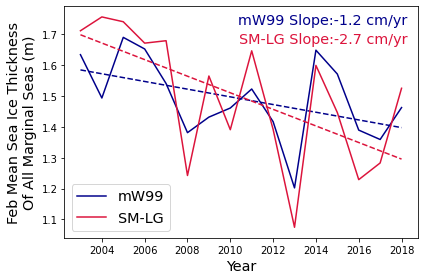

In [61]:


mw_stats = linregress(subset['year'],subset['all mW99 thickness'])
SM_stats = linregress(subset['year'],subset['all SM thickness'])

mw_trendline = mw_stats[0]*np.array(subset['year'])+mw_stats[1]
SM_trendline = SM_stats[0]*np.array(subset['year'])+SM_stats[1]

plt.plot(subset['year'],subset['all mW99 thickness'],color='darkblue',label='mW99')
plt.plot(subset['year'],mw_trendline,color='darkblue', ls='--')


plt.plot(subset['year'],subset['all SM thickness'],color='crimson',label='SM-LG')
plt.plot(subset['year'],SM_trendline,color='crimson', ls='--')

plt.annotate(xy=(0.97,0.89),xycoords='axes fraction', va='top', ha='right',fontsize='x-large',
             text=f'SM-LG Slope:{np.round(SM_stats[0]*100,decimals=1)} cm/yr',color='crimson')


plt.annotate(xy=(0.97,0.97),xycoords='axes fraction', va='top', ha='right',fontsize='x-large',
             text=f'mW99 Slope:{np.round(mw_stats[0]*100,decimals=1)} cm/yr',color='darkblue')


plt.legend(loc='lower left', fontsize='x-large')
plt.ylabel('Feb Mean Sea Ice Thickness\nOf All Marginal Seas (m)',fontsize='x-large')
plt.xlabel('Year', fontsize='x-large')

plt.tight_layout()

plt.savefig('Marginals.jpg',dpi=500)

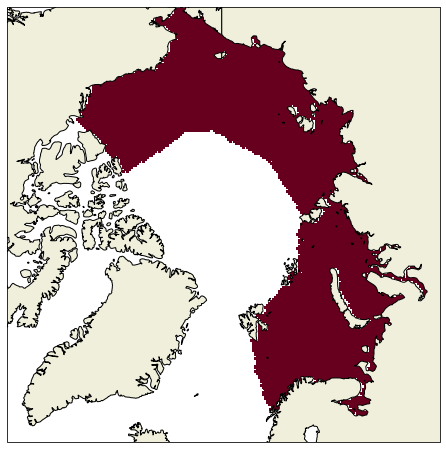

In [62]:
import cartopy.crs as ccrs
import cartopy


    

m = mask.get('mask')

m = np.isin(m,[8,9,10,11,12,13]).astype(np.float32)

m[m==0] = np.nan


lons = mask.get('lon')
lats = mask.get('lat')


fig = plt.figure(figsize=(8,8))    

ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1,alpha=1)

ax.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())

ax.pcolormesh(lons,lats,m[:-1,:-1], vmin = 0, vmax = 1,
                 transform=ccrs.PlateCarree(),
              zorder=0,cmap='RdBu_r',label='Margianls')

plt.savefig('Marginal_seas.jpg',dpi=500)


In [27]:
mask.region_codes()

{'Lakes': 0,
 'Oceans': 1,
 'Okhotsk': 2,
 'Bering': 3,
 'Hudson': 4,
 'St Lawrence': 5,
 'Baffin': 6,
 'Greenland': 7,
 'Barents': 8,
 'Kara': 9,
 'Laptev': 10,
 'East Siberian': 11,
 'Chukchi': 12,
 'Beaufort': 13,
 'Canadian Archipelago': 14,
 'Central Arctic': 15,
 'Land': 20,
 'Coast': 21}

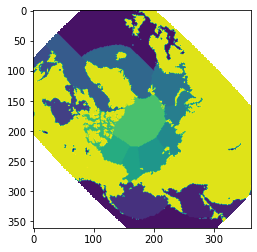

In [25]:
plt.imshow(m)

region:Barents, W99:0.17238888213648146, SM:0.304431428298012, %inc: 76.59574360311215
region:Kara, W99:0.0930352885726964, SM:0.22221517398085408, %inc: 138.8504162130033
region:Laptev, W99:0.11431650612546289, SM:0.2150640420355896, %inc: 88.13034908498325
region:East Siberian, W99:0.13844144693238888, SM:0.24988048862130843, %inc: 80.49543265994859
[0.20734386212220424, 0.17167823318180006, 0.2055225815451266, 0.23085915294550838, 0.2765205923013282, 0.33631705569680276, 0.3209219425563887]
region:Chukchi, W99:0.10587088360401313, SM:0.20899315772441376, %inc: 97.40380981999444
region:Beaufort, W99:0.19879524723651462, SM:0.2685540402445513, %inc: 35.09077504506025
region:Marginals, W99:0.09131688491274549, SM:0.16131168221696926, %inc: 76.65044353090312
region:Central Arctic, W99:0.1651724928117215, SM:0.20678567060330494, %inc: 25.19376990878129


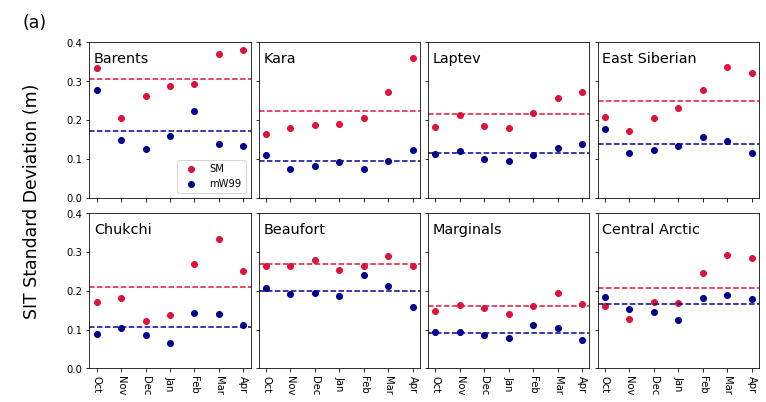

In [13]:
def abs_var_summary(all_trends_dict, a_var_fig_name):

    fig = plt.figure(figsize=(12,6))

    for subplot_counter, key in enumerate(region_list, 1):

        ax = plt.subplot(2,4,subplot_counter)

        region_data = all_trends_dict[key]

        SM_trends, W99_trends = [], []

        for month in rea(month_list):

            SM_trends.append(region_data[month][2])
            W99_trends.append(region_data[month][3])

        W99_ave = np.nanmean(W99_trends)
        SM_ave = np.nanmean(SM_trends)

        ax.axhline(SM_ave,color='crimson',linestyle='--')

        ax.axhline(W99_ave,color='darkblue',linestyle='--')

        print(f'region:{key}, W99:{W99_ave}, SM:{SM_ave}, %inc: {(SM_ave-W99_ave)*100/W99_ave}')

        ax.scatter(month_name_list_full,SM_trends,label='SM',color='crimson')

        ax.scatter(month_name_list_full,W99_trends,label='mW99',color='darkblue')

        if key == 'East Siberian':
            print(SM_trends)

        # Legend

        if subplot_counter == 1:
            ax.legend(loc='lower right')

        ax.annotate(key,
                      xy = (0.03,0.87),xycoords='axes fraction',
                      ha='left',fontsize="x-large",color='k')

        ax.set_ylim(0,0.4)

        if subplot_counter in [2,3,4,6,7,8]:
            ax.set_yticklabels([])

        if subplot_counter in [1,2,3,4]:
            ax.set_xticks(ticks=month_name_list_full)
            ax.set_xticklabels([])
        else:
            ax.set_xticks(ticks=month_name_list_full)
            ax.set_xticklabels(month_name_list_short,rotation = 270)




    plt.subplots_adjust(wspace=0.05, hspace=0.1)

    plt.annotate("SIT Standard Deviation (m)",
                     xy = (0.03,0.5),
                     xycoords="figure fraction",
                     rotation=90,
                     fontsize="xx-large",
                     va='center')

    plt.annotate("(a)",
                     xy = (0.03,0.93),
                     xycoords="figure fraction",
                     fontsize="xx-large",
                     ha='left')

    plt.savefig(a_var_fig_name,dpi=600,bbox_inches='tight')

    plt.show()

a_var_fig_name="variation_comparison_absolute.png"
abs_var_summary(all_trends_dict, a_var_fig_name)


# a_var_fig_name="variation_comparison_absolute_adj.png"
# abs_var_summary(all_trends_dict_adj, a_var_fig_name)

region:Barents, W99:14.816407670026665, SM:25.20308795929331, %inc: 10.386680289266645
region:Kara, W99:9.628679493481519, SM:17.63867607197438, %inc: 8.009996578492862
region:Laptev, W99:10.102785916701281, SM:18.998997526028194, %inc: 8.896211609326913
region:East Siberian, W99:11.37311323672277, SM:19.877426372175147, %inc: 8.504313135452378
[32.84106402 21.36885725 19.10400792 16.98201748 17.0109484  17.36654688
 14.46854265]
region:Chukchi, W99:8.384963983345607, SM:18.612072686380483, %inc: 10.227108703034876
region:Beaufort, W99:14.712111889446481, SM:22.058930116586254, %inc: 7.346818227139773
SM_std: 13.80719492976071, W99_std: 7.512213204429921
region:Marginals, W99:7.512213204429921, SM:13.80719492976071, %inc: 6.294981725330789
region:Central Arctic, W99:7.858026037660244, SM:9.389158286742274, %inc: 1.53113224908203


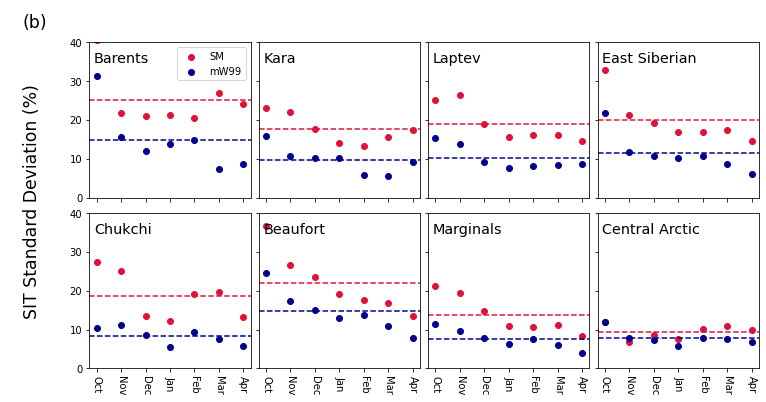

In [14]:
fig = plt.figure(figsize=(12,6))

for subplot_counter, key in enumerate(region_list, 1):
    
    ax = plt.subplot(2,4,subplot_counter)
    
    region_data = all_trends_dict[key]

    SM_trends, W99_trends = [], []
    SM_means, W99_means = [], []
    
    for month in rea(month_list):
        
        SM_trends.append(region_data[month][2])
        SM_means.append(region_data[month][-2])
        W99_trends.append(region_data[month][3])
        W99_means.append(region_data[month][-1])
        
    SM_trends = np.divide(SM_trends,SM_means)*100
    W99_trends = np.divide(W99_trends,W99_means)*100
    
    W99_ave = np.nanmean(W99_trends)
    SM_ave = np.nanmean(SM_trends)
    
    if key == 'Marginals':
        print(f'SM_std: {SM_ave}, W99_std: {W99_ave}')
    
    ax.axhline(SM_ave,color='crimson',linestyle='--')
    
    ax.axhline(W99_ave,color='darkblue',linestyle='--')
    
    print(f'region:{key}, W99:{W99_ave}, SM:{SM_ave}, %inc: {(SM_ave-W99_ave)}')
    
    ax.scatter(month_name_list_full,SM_trends,label='SM',color='crimson')
    
    ax.scatter(month_name_list_full,W99_trends,label='mW99',color='darkblue')
    
    if key == 'East Siberian':
        print(SM_trends)
    
    # Legend
    
    if subplot_counter == 1:
        ax.legend(loc='upper right')
        
    ax.annotate(key,
                  xy = (0.03,0.87),xycoords='axes fraction',
                  ha='left',fontsize="x-large",color='k')
    
    ax.set_ylim(0,40)
    
    if subplot_counter in [2,3,4,6,7,8]:
        ax.set_yticklabels([])
    
    if subplot_counter in [1,2,3,4]:
        ax.set_xticks(ticks=month_name_list_full)
        ax.set_xticklabels([])
    else:
        ax.set_xticks(ticks=month_name_list_full)
        ax.set_xticklabels(month_name_list_short,rotation = 270)
        

    
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.annotate("SIT Standard Deviation (%)",
                 xy = (0.03,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

plt.annotate("(b)",
                 xy = (0.03,0.93),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='left')

b_var_fig_name = "variation_comparison_percent.png"
plt.savefig(b_var_fig_name,dpi=600,bbox_inches='tight')

plt.show()


dir_to_combine = f'{dir_to_save}/Figures/'
str_to_pass = f'convert {a_var_fig_name} {b_var_fig_name} -append {dir_to_combine}output_vars.png'
!{str_to_pass}

region:Laptev, W99:-0.0267282429419175, SM:-0.04334778843869166
% increase: 0.6217971578936067
region:Kara, W99:-0.03595657847836823, SM:-0.06515237285389344
% increase: 0.8119736529739513
region:Chukchi, W99:-0.027483876290453745, SM:-0.04483399722841466
% increase: 0.6312836207892302
region:Barents, W99:-0.03027667306730929, SM:-0.061340942163605826
% increase: 1.0260132950286944


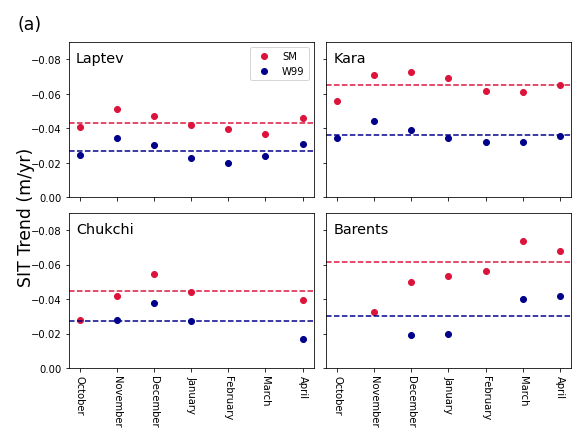

In [15]:

def abs_trends_summary(all_trends_dict, a_fig_name):

    fig = plt.figure(figsize=(9,6))

    for subplot_counter, key in enumerate(['Laptev', 'Kara', 'Chukchi', 'Barents'], 1):

        ax = plt.subplot(2,2,subplot_counter)

        region_data = all_trends_dict[key]

    #     print(region_data)

        SM_trends, W99_trends = [], []
        SM_trends_m, W99_trends_m = [], []

        for month in rea(month_list):
            
            SM_trends.append(region_data[month][0])
            W99_trends.append(region_data[month][1])
            
            if ~np.isnan(region_data[month]).any():
                SM_trends_m.append(region_data[month][0])
                W99_trends_m.append(region_data[month][1])
        
        W99_ave = np.nanmean(W99_trends_m)
        SM_ave = np.nanmean(SM_trends_m)

    #     print(key,np.around(SM_ave,decimals=3),np.around(W99_ave,decimals=3),np.around(SM_ave-W99_ave,decimals))

        ax.axhline(SM_ave,color='crimson',linestyle='--')

        ax.axhline(W99_ave,color='darkblue',linestyle='--')

        print(f'region:{key}, W99:{W99_ave}, SM:{SM_ave}')
        print(f'% increase: {(SM_ave-W99_ave)/W99_ave}')

        ax.scatter(month_name_list_full,SM_trends,label='SM',color='crimson')

        ax.scatter(month_name_list_full,W99_trends,label='W99',color='darkblue')

        # Legend

        if subplot_counter == 1: ax.legend(loc='upper right')

        # x ticks

        if subplot_counter in [1,2]:
            ax.set_xticks(ticks=month_name_list_full)
            ax.set_xticklabels([])
        else:
            ax.set_xticks(ticks=month_name_list_full)
            ax.set_xticklabels(month_name_list_full,rotation = 270)

        # y ticks

        yticks = np.linspace(0,-0.08,5)

        if subplot_counter in [2,4]:
            ax.set_yticks(ticks=yticks)
            ax.set_yticklabels([])
        else:
            ax.set_yticks(ticks=yticks)

        ax.set_ylim(0,-0.09)

        ax.annotate(key,
                          xy = (0.03,0.87),xycoords='axes fraction',
                          ha='left',fontsize="x-large",color='k')



    plt.subplots_adjust(wspace=0.05, hspace=0.1)

    plt.annotate("SIT Trend (m/yr)",
                     xy = (0.03,0.5),
                     xycoords="figure fraction",
                     rotation=90,
                     fontsize="xx-large",
                     va='center')

    plt.annotate("(a)",
                     xy = (0.03,0.93),
                     xycoords="figure fraction",
                     fontsize="xx-large",
                     ha='left')
    

    plt.savefig(a_fig_name,dpi=600,bbox_inches='tight')

    plt.show()

a_fig_name = "trend_comparison_absolute.png"

a_adj_fig_name = "trend_comparison_absolute_adj.png"



abs_trends_summary(all_trends_dict, a_fig_name)

# abs_trends_summary(all_trends_dict_adj, a_adj_fig_name)

# abs_trends_summary(all_trends_dict_NS)

region:Laptev, W99:-2.414287775017557, SM:-4.025968758695252
percent increase: 0.6675596009535254
region:Kara, W99:-3.854196179325779, SM:-5.61717939736552
percent increase: 0.4574191701752303
region:Chukchi, W99:-2.5062509777422757, SM:-4.442926650056925
percent increase: 0.7727381214068507
region:Barents, W99:-2.115605224281824, SM:-4.177427417237245
percent increase: 0.9745779454932758


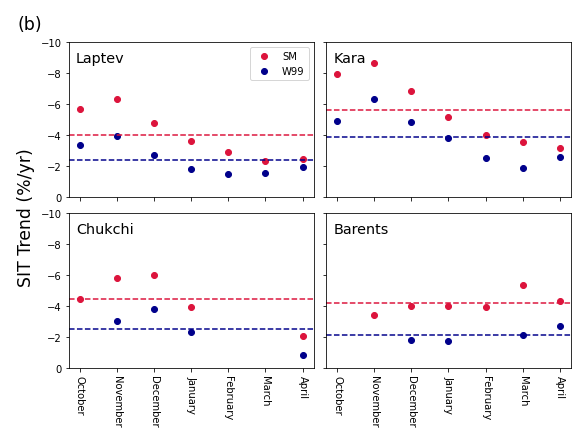

In [16]:
def rel_trends_summary():

    fig = plt.figure(figsize=(9,6))

    for subplot_counter, key in enumerate(['Laptev', 'Kara', 
                                           'Chukchi',
                                           'Barents',
#                                            'Marginals',
                                          ], 1):

        region_data = all_trends_dict[key]

        SM_trends, W99_trends = [], []
        SM_means, W99_means = [], []

        for month in rea(month_list):
            SM_trends.append(region_data[month][0])
            SM_means.append(region_data[month][-2])
            W99_trends.append(region_data[month][1])
            W99_means.append(region_data[month][-1])

        SM_trends = np.divide(SM_trends,SM_means)*100
        W99_trends = np.divide(W99_trends,W99_means)*100

        W99_ave = np.nanmean(W99_trends)
        SM_ave = np.nanmean(SM_trends)

        if key == 'Marginals':
            print(f'SM_std: {SM_ave}, W99_std: {W99_ave}')

    #     print(key,np.around(SM_ave,decimals=3),np.around(W99_ave,decimals=3),np.around(SM_ave-W99_ave,decimals))

        print(f'region:{key}, W99:{W99_ave}, SM:{SM_ave}')
        print(f'percent increase: {(SM_ave-W99_ave)/W99_ave}')

        ax = plt.subplot(2,2,subplot_counter)

        ax.axhline(SM_ave,color='crimson',linestyle='--')

        ax.axhline(W99_ave,color='darkblue',linestyle='--')

        ax.scatter(month_name_list_full,SM_trends,label='SM',color='crimson')

        ax.scatter(month_name_list_full,W99_trends,label='W99',color='darkblue')

        if subplot_counter in [2,4]:
            ax.set_yticklabels([])

        # Legend

        if subplot_counter == 1:
            ax.legend(loc='upper right')

        # x ticks

        if subplot_counter in [1,2]:
            ax.set_xticks(ticks=month_name_list_full)
            ax.set_xticklabels([])
        else:
            ax.set_xticks(ticks=month_name_list_full)
            ax.set_xticklabels(month_name_list_full,rotation = 270)

        # y ticks

    #     yticks = np.linspace(0,-0.08,5)


        ax.set_ylim(0,-10)

        # Region Annotation

        xy = (0.03,0.87)

        ax.annotate(key,
                          xy = xy,xycoords='axes fraction',
                          ha='left',fontsize="x-large",color='k')



    plt.subplots_adjust(wspace=0.05, hspace=0.1)

    plt.annotate("SIT Trend (%/yr)",
                     xy = (0.03,0.5),
                     xycoords="figure fraction",
                     rotation=90,
                     fontsize="xx-large",
                     va='center')

    plt.annotate("(b)",
                     xy = (0.03,0.93),
                     xycoords="figure fraction",
                     fontsize="xx-large",
                     ha='left')

    b_fig_name = "trend_comparison_percent.png"

    plt.savefig(b_fig_name,dpi=600,bbox_inches='tight')

    plt.show()

    dir_to_combine = f'{dir_to_save}/Figures/'
    str_to_pass = f'convert {a_fig_name} {b_fig_name} -append {dir_to_combine}output_trends.png'
    !{str_to_pass}
    
    
rel_trends_summary()

In [17]:
np.arange(-0.7,0.71,0.2)

array([-0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7])

all


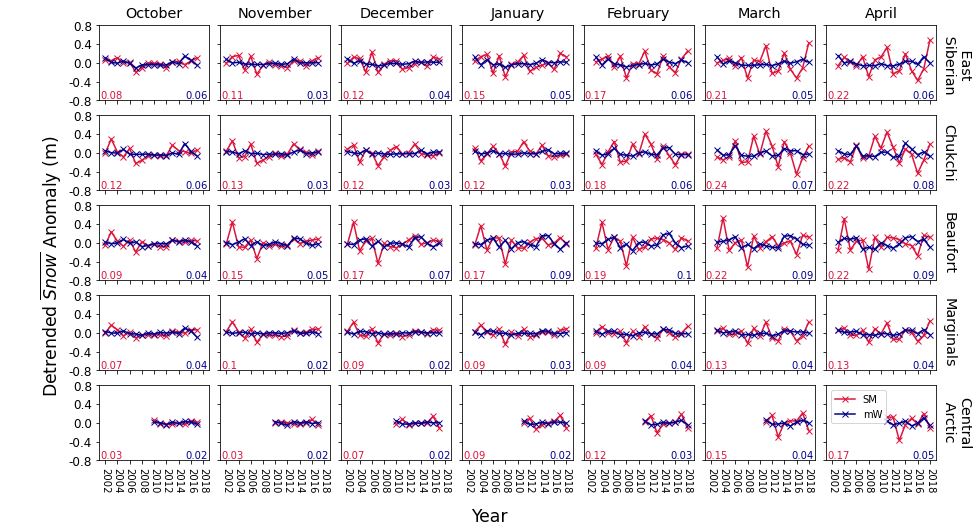

In [18]:
def snow_contribution_timeseries_limited(ice_type,snow_product, beta):
  
    print(ice_type)

    fig = plt.figure(figsize=(15,8))
    
    limited_regions = [  'East Siberian',
                         'Chukchi',
                         'Beaufort',
                         'Marginals',
                         'Central Arctic']
    
    total_subplots = len(limited_regions)*len(month_list)
    
    for subplot_counter, (region, month) in enumerate(itertools.product(limited_regions, rea(month_list)), 1):

        ax = plt.subplot(len(limited_regions),len(month_list),subplot_counter)

        W99_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        W99 = list(W99_subset[f'{ice_type} mW99 contribution'])

        SM_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        SM = list(SM_subset[f'{ice_type} {snow_product} contribution'])

        yearlist = list(SM_subset['year'])

        ##################################################################

        # Detrend the data

        W99 = detrender(yearlist,W99)
        SM = detrender(yearlist,SM)

        ###################################################################

        # Calculate statistics and color frames

        SM_var = np.round(np.nanstd(SM), decimals=2)
        W99_var = np.round(np.nanstd(W99), decimals=2)


        if region == 'Central Arctic':
        
            SM = np.array(    list(np.full(8,np.nan)) + list(SM)  )
            W99 = np.array(   list(np.full(8,np.nan)) + list(W99) )

            yearlist = np.array(   list(range(2002,2010)) + list(yearlist) )


        ########################################################################

        # Make the line plots
        
        snow_label = 'SM' if snow_product == 'SM' else 'NS'
        
        ax.plot(yearlist,SM,
                      marker='x',label=snow_label,color='crimson')

        ax.plot(yearlist,W99,
                      marker='x',label='mW',color='darkblue')
        
        ax.annotate(SM_var, xy = (0.01,0.02), xycoords = 'axes fraction',color='crimson')
        ax.annotate(W99_var, xy = (0.99,0.02), xycoords = 'axes fraction',color='darkblue', ha='right')

        # Set y axis limits

        scale = 0.8
        ax.set_ylim(-scale,scale)

        # Month name annotations

        if subplot_counter < 8:

            ax.annotate(month_name_list_full[subplot_counter-1],
                              xy = (0.5,1.1),xycoords='axes fraction',
                              fontsize="x-large",ha='center')

        # Region Name Annotations

        if subplot_counter %7 == 0:

            if region == 'Central Arctic':
                region_name = 'Central\n Arctic'
            elif region == 'East Siberian':
                region_name = '    East\n Siberian'
            else:
                region_name = region
            
            ax.annotate(region_name,xy = (1.05,0.5),
                              xycoords='axes fraction',
                              fontsize='x-large',
                              va='center',
                              ha='left',
                              rotation=270)

        # Make y ticks

        yticks = np.arange(-scale,scale+0.01,0.4)
        yticks = np.around(yticks,decimals=1)
        ylabels = yticks

        if (subplot_counter-1) %7 == 0:
            ax.set_yticks(ticks=yticks)
            ax.set_yticklabels(ylabels,fontsize='large')
        else:
            ax.set_yticks(ticks=yticks)
            ax.set_yticklabels([])

        # Make x ticks
        ax.set_xlim(2001,2019)
        if subplot_counter <= total_subplots-7:
            ax.set_xticks(ticks=list(range(2002,2019,2)))
            ax.set_xticklabels([])
        else:
            ax.set_xticks(np.arange(2002,2019,2))
            ax.tick_params('x',rotation = 270)

        # Make legend

        if subplot_counter == total_subplots:
            ax.legend(fontsize='medium',loc='upper left')

    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    
    snowbar = r'$\overline{Snow}$'
    
    plt.annotate(f"Detrended {snowbar} Anomaly (m)",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

    plt.annotate("Year",
                 xy = (0.5,0.02),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')

    plt.savefig(f"{dir_to_save}/Figures/{snow_product}_{ice_type}_detrended_variability.png",dpi=400,bbox_inches='tight')

    plt.show()
    

snow_contribution_timeseries_limited('all','SM', beta)


# Below here is where the supplementary figs get made

all


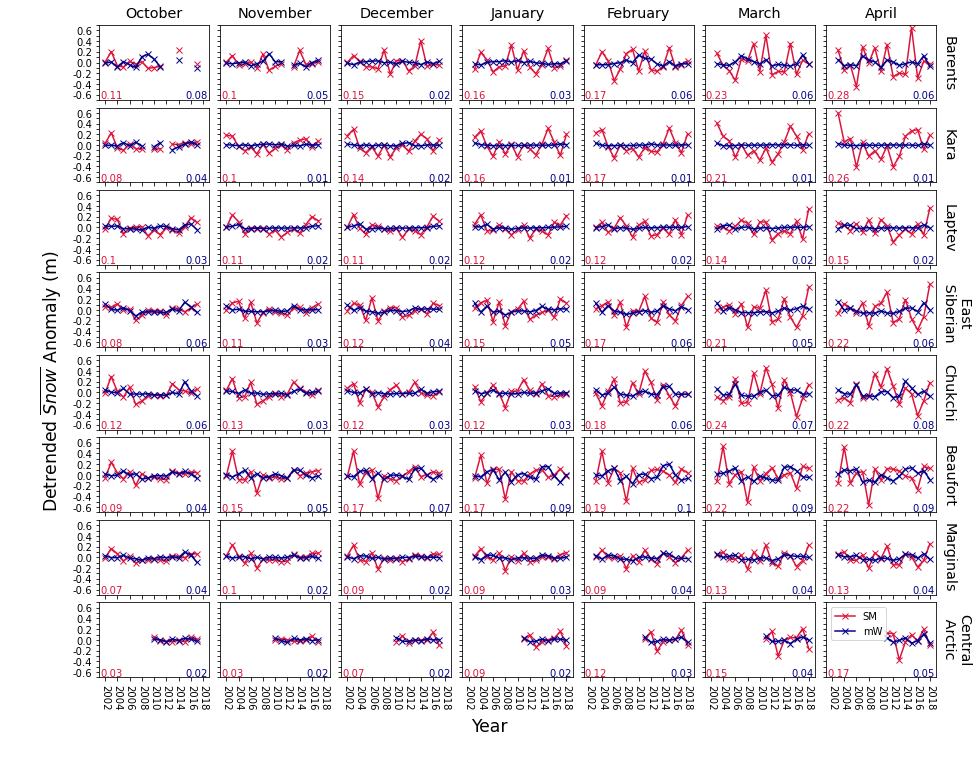

FYI


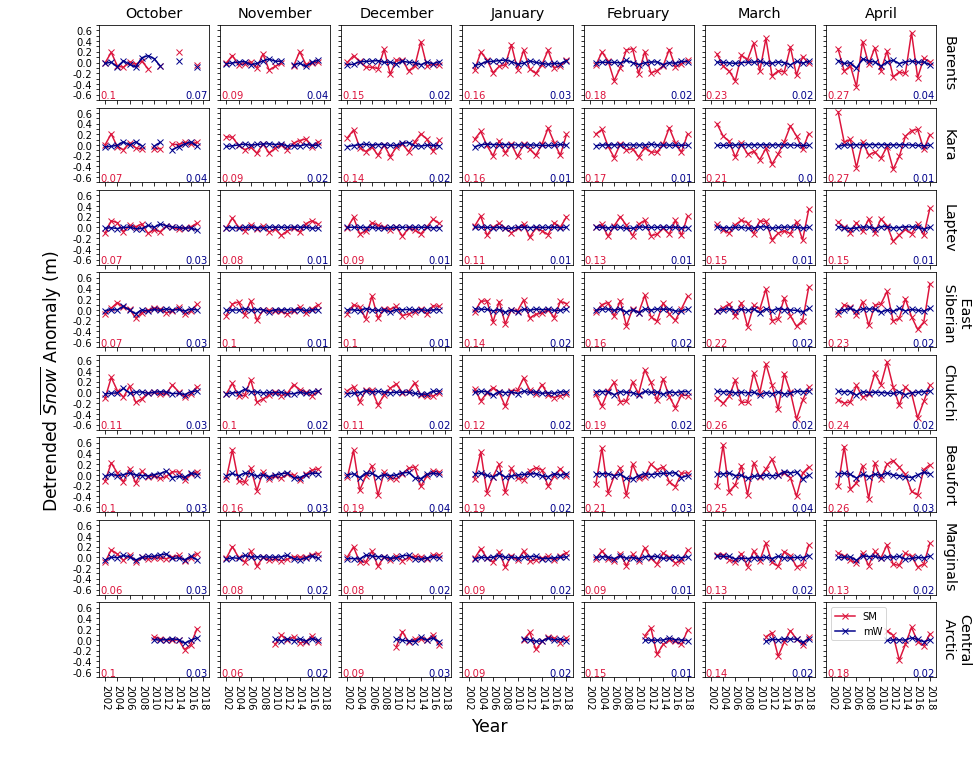

MYI


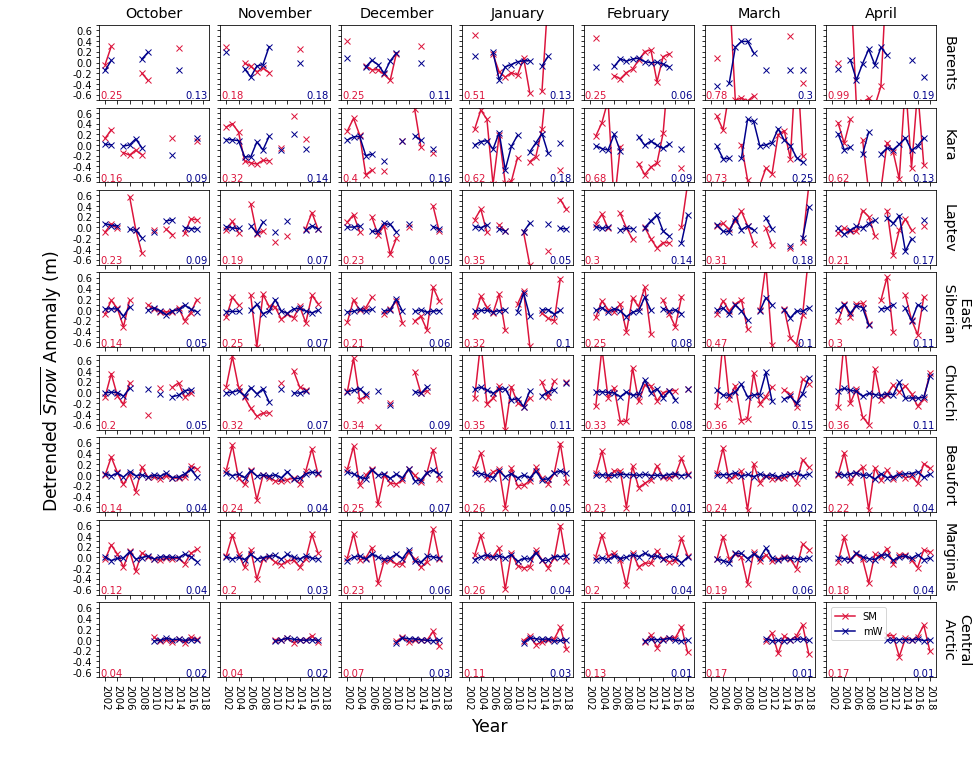

all


/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


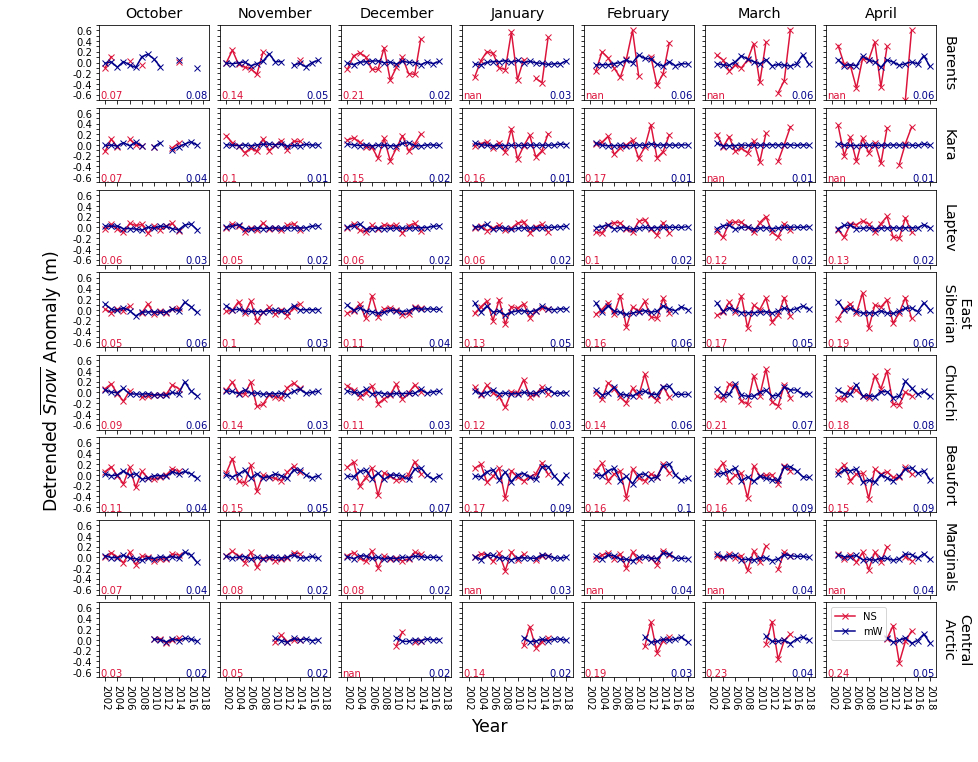

In [24]:
def snow_contribution_timeseries(ice_type,snow_product, beta):
  
    print(ice_type)

    fig = plt.figure(figsize=(15,12))
    
    total_subplots = len(region_list)*len(month_list)
    
    for subplot_counter, (region, month) in enumerate(itertools.product(region_list, rea(month_list)), 1):

        ax = plt.subplot(len(region_list),len(month_list),subplot_counter)

        W99_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        W99 = list(W99_subset[f'{ice_type} mW99 contribution'])

        SM_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        SM = list(SM_subset[f'{ice_type} {snow_product} contribution'])

        yearlist = list(SM_subset['year'])

        ##################################################################

        # Detrend the data

        W99 = detrender(yearlist,W99)
        SM = detrender(yearlist,SM)

        ###################################################################

        # Calculate statistics and color frames

        SM_var = np.round(np.nanstd(SM), decimals=2)
        W99_var = np.round(np.nanstd(W99), decimals=2)


        if region == 'Central Arctic':
        
            SM = np.array(    list(np.full(8,np.nan)) + list(SM)  )
            W99 = np.array(   list(np.full(8,np.nan)) + list(W99) )

            yearlist = np.array(   list(range(2002,2010)) + list(yearlist) )


        ########################################################################

        # Make the line plots
        
        snow_label = 'SM' if snow_product == 'SM' else 'NS'
        
        ax.plot(yearlist,SM,
                      marker='x',label=snow_label,color='crimson')

        ax.plot(yearlist,W99,
                      marker='x',label='mW',color='darkblue')
        
        ax.annotate(SM_var, xy = (0.01,0.02), xycoords = 'axes fraction',color='crimson')
        ax.annotate(W99_var, xy = (0.99,0.02), xycoords = 'axes fraction',color='darkblue', ha='right')

        # Set y axis limits

        scale = 0.7
        ax.set_ylim(-scale,scale)

        # Month name annotations

        if subplot_counter < 8:

            ax.annotate(month_name_list_full[subplot_counter-1],
                              xy = (0.5,1.1),xycoords='axes fraction',
                              fontsize="x-large",ha='center')

        # Region Name Annotations

        if subplot_counter %7 == 0:

            if region == 'Central Arctic':
                region_name = 'Central\n Arctic'
            elif region == 'East Siberian':
                region_name = '    East\n Siberian'
            else:
                region_name = region
            
            ax.annotate(region_name,xy = (1.05,0.5),
                              xycoords='axes fraction',
                              fontsize='x-large',
                              va='center',
                              ha='left',
                              rotation=270)

        # Make y ticks

        yticks = np.linspace(-scale,scale,15)
        yticks = np.around(yticks,decimals=1)
        ylabels = [x if (x*10)%2 == 0 else ""  for x in yticks]


        if (subplot_counter-1) %7 == 0:
            ax.set_yticks(ticks=yticks)
            ax.set_yticklabels(ylabels)
        else:
            ax.set_yticks(ticks=yticks)
            ax.set_yticklabels([])

        # Make x ticks
        ax.set_xlim(2001,2019)
        if subplot_counter <= total_subplots-7:
            ax.set_xticks(ticks=list(range(2002,2019,2)))
            ax.set_xticklabels([])
        else:
            ax.set_xticks(np.arange(2002,2019,2))
            ax.tick_params('x',rotation = 270)

        # Make legend

        if subplot_counter == total_subplots:
            ax.legend(fontsize='medium',loc='upper left')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    snowbar = r'$\overline{Snow}$'
    
    plt.annotate(f"Detrended {snowbar} Anomaly (m)",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

    plt.annotate("Year",
                 xy = (0.5,0.04),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')

    plt.savefig(f"{dir_to_save}/Sup_Figs/{snow_product}_{ice_type}_detrended_variability.png",dpi=400,bbox_inches='tight')

    plt.show()
    
    
for ice_type in ['all',
                 'FYI',
                 'MYI']:
    snow_contribution_timeseries(ice_type,'SM', beta)
    
    
snow_contribution_timeseries('all','NS', beta)

all


/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib

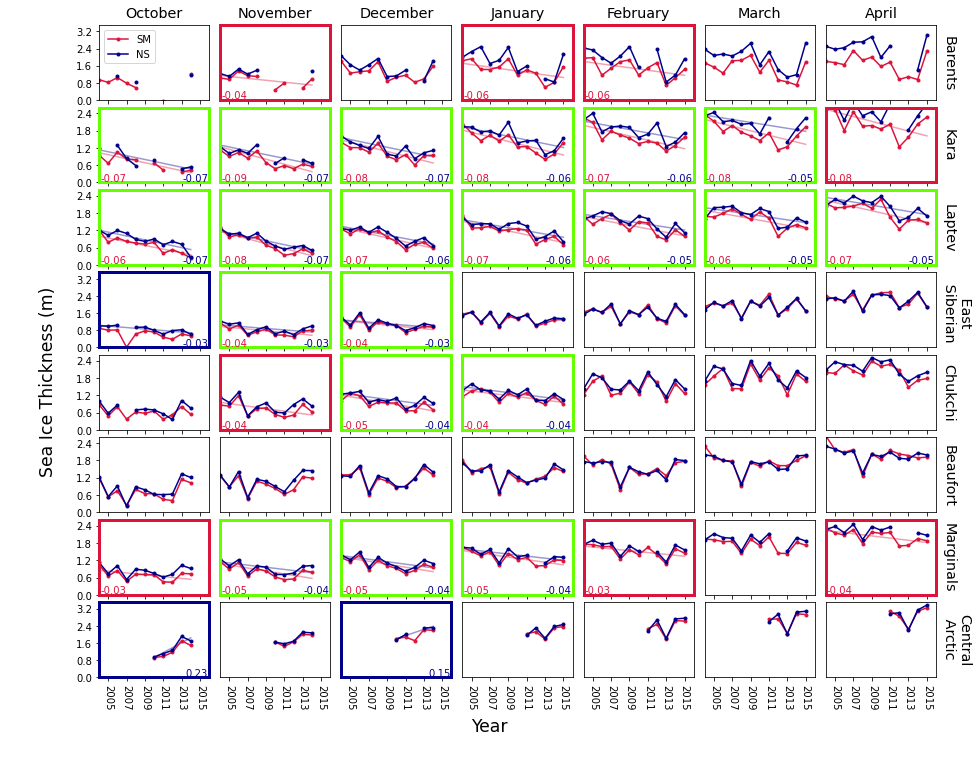

MYI


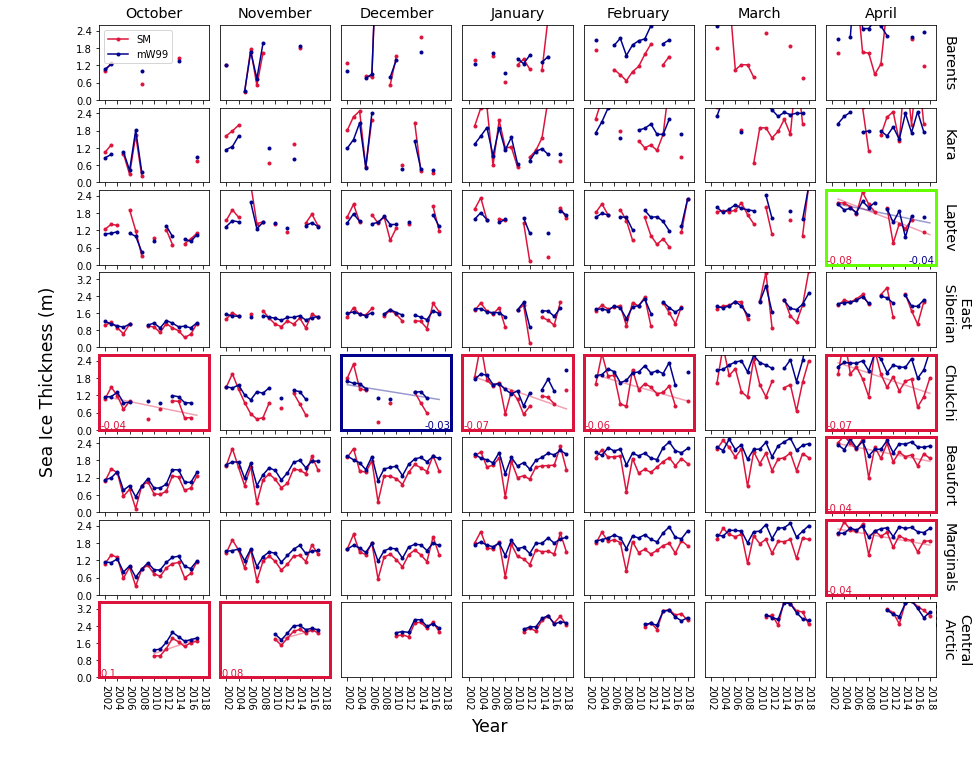

FYI


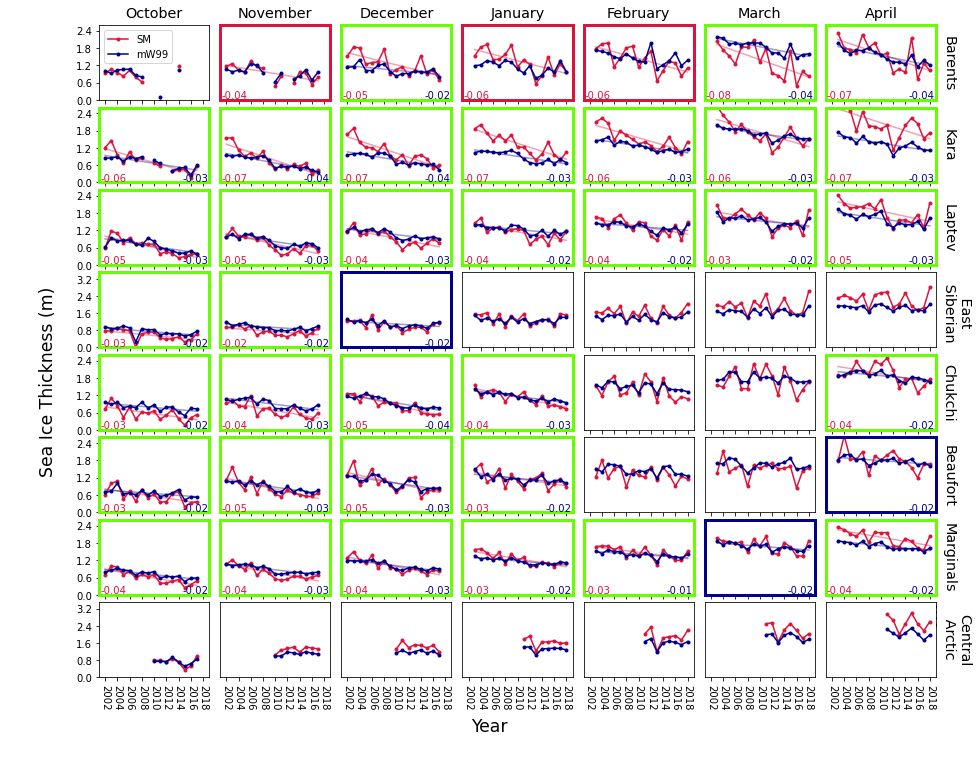

In [25]:
all_trends_dict_NS = timeseries('all', 'SM', 'NS', beta)
MYI_trends_dict = timeseries('MYI','SM','mW99', beta)
FYI_trends_dict = timeseries('FYI','SM','mW99', beta)

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


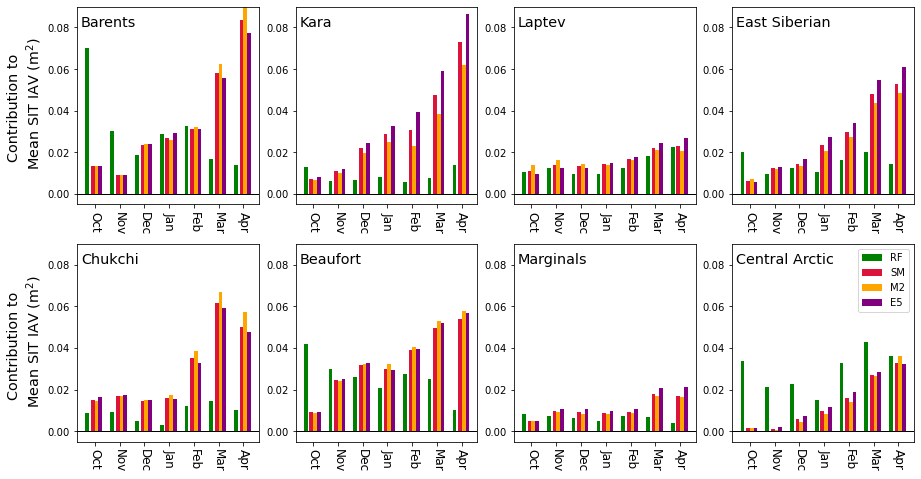

In [38]:
keys = ['M2','E5','SM']

def compare_reanalyses(list_of_frames,dict_of_codes):

    fig = plt.figure(figsize=(15,8))
    
    bw = 0.15
    
    for c, snow_code in zip(list_of_frames, dict_of_codes.keys()):

        for subplot_counter, region in enumerate(region_list, 1):

            subset = c[c['region'] == region]

            fb_var = subset['freeboard_var']
            sm_var = subset['snow_var']

            x = np.array(range(len(fb_var)))

            ax = plt.subplot(2,4,subplot_counter)
            
            if snow_code == 'SM':
                ax.bar(x-(2*bw), fb_var, width=bw, color='green', align='center',label='RF')
                

                ax.set_xticks([0,1,2,3,4,5,6])
                ax.set_xticklabels(month_name_list_short,
                                fontsize='large',rotation=270)


                ax.annotate(region,xy = (0.02,0.9),xycoords='axes fraction',fontsize='x-large')
                ax.axhline(y=0, color='k', linewidth = 1)

                if snow_code == 'SM':
                    ax.set_ylim(-0.005,0.09)
                elif snow_code == 'NS':
                    ax.set_ylim(-0.015,0.1)

                if subplot_counter in [1,5]:
                    ax.set_ylabel('Contribution to \n Mean SIT IAV (m$^2$)', fontsize = 'x-large')
                
            ax.bar(x+(dict_of_codes[snow_code][0]*bw), sm_var, width=bw, align='center',label=snow_code,color=dict_of_codes[snow_code][1])

    ax.legend(fontsize='medium',loc='upper right')

    fig.savefig(f'{dir_to_save}/Sup_Figs/reanalysis_variability_comparison.png',
                dpi=450, bbox_inches='tight')

    plt.show()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    
    compare_reanalyses([c, c_M2, c_E5], {'SM':(-0.5,'crimson'), 'M2':(0.5,'orange'), 'E5':(1.5,'purple')})

In [ ]:
def snow_contribution_timeseries(ice_type):
    
    print(ice_type)

    fig = plt.figure(figsize=(15,12))

    total_subplots = len(region_list) * len(month_list)
    
    for subplot_counter, (region, month) in enumerate(itertools.product(region_list, rea(month_list)), 1):

        ax = plt.subplot(len(region_list),len(month_list),subplot_counter)

        W99_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        W99 = list(W99_subset[f'{ice_type} free contribution'])

        SM_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        SM = list(SM_subset[f'{ice_type} SM contribution'])

        yearlist = list(SM_subset['year'])

        ##################################################################

        # Detrend the data

        W99 = detrender(yearlist,W99)
        SM = detrender(yearlist,SM)

        ###################################################################

        # Calculate statistics and color frames

        SM_var = np.nanstd(SM)
        W99_var = np.nanstd(W99)

        if region == "Central Arctic":
            SM = np.array(    list(np.full(8,np.nan)) + list(SM)  )
            W99 = np.array(   list(np.full(8,np.nan)) + list(W99) )

            yearlist = np.array(   list(range(2002,2010)) + list(yearlist) )

        ########################################################################

        # Make the line plots

        ax.plot(yearlist,SM,
                      marker='x',label='SM',color='crimson')

        ax.plot(yearlist,W99,
                      marker='x',label='RF',color='green')


#             ax = plt.annotate(r'$\sigma(SM) = ' + str(SM_var) + r'$\sigma(mW99) = ' + str(W99_var),
#                               fontsize='large',
#                               xy = (0.03,0.03),
#                               xycoords='axes fraction',
#                               ha='left',color='k')

        # Set y axis limits

        scale = 0.7
        ax.set_ylim(-scale,scale)

#             if region in ["Central Arctic", "Kara"]:
#                 ax = plt.ylim(0,2)
#             elif region in ["Barents","Beaufort", "East Siberian", "Laptev"]:
#                 plt.ylim(0,1.6)

        # Month name annotations

        if subplot_counter <= len(month_list):

            ax.annotate(month_name_list_full[subplot_counter-1],
                              xy = (0.5,1.1),xycoords='axes fraction',
                              fontsize="x-large",ha='center')

        # Region Name Annotations


        if subplot_counter% 7 == 0:
            
            if region == 'Central Arctic':
                region_name = 'Central\n Arctic'
            elif region == 'East Siberian':
                region_name = '    East\n Siberian'
            else:
                region_name = region
            
            ax.annotate(region_name,xy = (1.05,0.5),
                              xycoords='axes fraction',
                              fontsize='x-large',
                              va='center',
                              ha='left',
                              rotation=270)
        # Make y ticks

        yticks = np.linspace(-scale,scale,15)
        yticks = np.around(yticks,decimals=1)
        ylabels = [x if (x*10)%2 == 0 else ""  for x in yticks]


#             if region in ["Central Arctic",  "Kara"]:
#                 yticks = np.linspace(0,1.8,7)
#                 yticks = np.around(yticks,decimals=2)
#             else:
#                 yticks = np.linspace(0,1.4,8)
#                 yticks = np.around(yticks,decimals=2)

        if (subplot_counter-1) % 7 == 0:
            ax.set_yticks(yticks)
            ax.set_yticklabels(ylabels)
        else:
            ax.set_yticks(yticks)
            ax.set_yticklabels([])

        # Make x ticks
        ax.set_xlim(2001,2019)
        if subplot_counter <= total_subplots-7:
            ax.set_xticks(ticks=list(range(2002,2019,2)))
            ax.set_xticklabels([])
        else:
            ax.set_xticks(np.arange(2002,2019,2))
            ax.tick_params('x',rotation = 270)

        # Make legend

        if subplot_counter == total_subplots:
            ax.legend(fontsize='medium',loc='upper left')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.annotate(r"Detrended SIT Component Anomaly (m)",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

    plt.annotate("Year",
                 xy = (0.5,0.04),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')

    if ice_type == 'all':
        sub_dir = 'Figures'
    else:
        sub_dir = 'Sup_Figs'
        
    plt.savefig(f"{dir_to_save}/{sub_dir}/{ice_type}_RF_SNOW_variability.png",dpi=500,bbox_inches='tight')

    plt.show()

a = snow_contribution_timeseries('all')
# b = snow_contribution_timeseries('FYI')
# c = snow_contribution_timeseries('MYI')

all


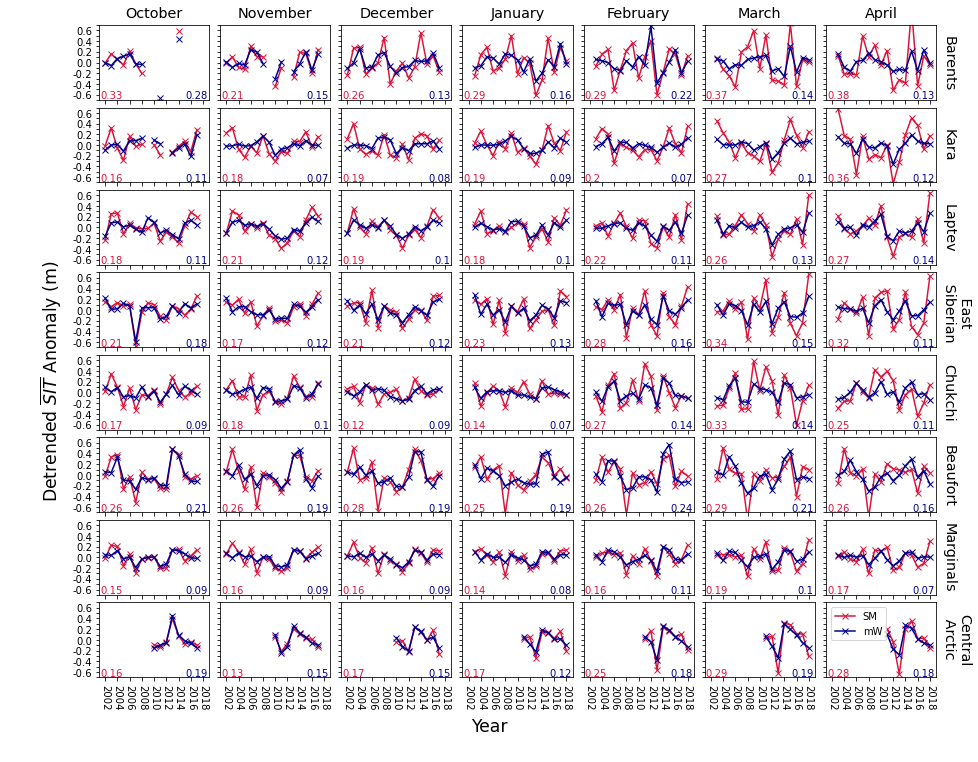

In [33]:
def SIT_contribution_timeseries(ice_type):
  
    print(ice_type)

    fig = plt.figure(figsize=(15,12))
    
    total_subplots = len(region_list) * len(month_list)
    
    for subplot_counter, (region, month) in enumerate(itertools.product(region_list, rea(month_list)), 1):

        ax = plt.subplot(len(region_list),len(month_list),subplot_counter)

        W99_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        W99 = list(W99_subset[f'{ice_type} mW99 thickness'])

        SM_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        SM = list(SM_subset[f'{ice_type} SM thickness'])

        yearlist = list(SM_subset['year'])

        ##################################################################

        # Detrend the data

        W99 = detrender(yearlist,W99)
        SM = detrender(yearlist,SM)

        ###################################################################

        # Calculate statistics and color frames

        SM_var = np.round(np.nanstd(SM), decimals=2)
        W99_var = np.round(np.nanstd(W99), decimals=2)


        if region == 'Central Arctic':
        
            SM = np.array(    list(np.full(8,np.nan)) + list(SM)  )
            W99 = np.array(   list(np.full(8,np.nan)) + list(W99) )

            yearlist = np.array(   list(range(2002,2010)) + list(yearlist) )


        ########################################################################

        # Make the line plots

        ax.plot(yearlist,SM,
                      marker='x',label='SM',color='crimson')

        ax.plot(yearlist,W99,
                      marker='x',label='mW',color='darkblue')
        
        ax.annotate(SM_var, xy = (0.01,0.02), xycoords = 'axes fraction',color='crimson')
        ax.annotate(W99_var, xy = (0.99,0.02), xycoords = 'axes fraction',color='darkblue', ha='right')
    
        # Set y axis limits

        scale = 0.7
        ax.set_ylim(-scale,scale)

        # Month name annotations

        if subplot_counter < 8:

            ax.annotate(month_name_list_full[subplot_counter-1],
                              xy = (0.5,1.1),xycoords='axes fraction',
                              fontsize="x-large",ha='center')

        # Region Name Annotations

        if subplot_counter %7 == 0:

            if region == 'Central Arctic':
                region_name = 'Central\n Arctic'
            elif region == 'East Siberian':
                region_name = '    East\n Siberian'
            else:
                region_name = region
            
            ax.annotate(region_name,xy = (1.05,0.5),
                              xycoords='axes fraction',
                              fontsize='x-large',
                              va='center',
                              ha='left',
                              rotation=270)

        # Make y ticks

        yticks = np.linspace(-scale,scale,15)
        yticks = np.around(yticks,decimals=1)
        ylabels = [x if (x*10)%2 == 0 else ""  for x in yticks]


        if (subplot_counter-1) % 7 == 0:
            ax.set_yticks(ticks=yticks)
            ax.set_yticklabels(ylabels)
        else:
            ax.set_yticks(ticks=yticks)
            ax.set_yticklabels([])

        # Make x ticks
        ax.set_xlim(2001,2019)
        if subplot_counter <= total_subplots-7:
            ax.set_xticks(ticks=list(range(2002,2019,2)))
            ax.set_xticklabels([])
        else:
            ax.set_xticks(np.arange(2002,2019,2))
            ax.tick_params('x',rotation = 270)

        # Make legend


        if subplot_counter == total_subplots:
            ax.legend(fontsize='medium',loc='upper left')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.annotate(r"Detrended $\overline{SIT}$ Anomaly (m)",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

    plt.annotate("Year",
                 xy = (0.5,0.04),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')

    plt.savefig(f"{dir_to_save}/Sup_Figs/{ice_type}_detrended_SIT_variability.png",dpi=450,bbox_inches='tight')

    plt.show()
    
    
for ice_type in ['all',
#                  'MYI',
#                  'FYI',
                ]:
    SIT_contribution_timeseries(ice_type)
# SIT_contribution_timeseries('all','NS')

# Now calculate variability by ice type

In [30]:
MYI_trends_dict['Laptev']['01']

(nan,
 nan,
 0.6204782221145878,
 0.24621510051228446,
 1.4455557971634654,
 1.5480460702808092)

region:Barents, W99:0.29289616319830947, SM:0.7826153252146139, %inc: 1.671988996608102
region:Kara, W99:0.2262202441497199, SM:0.6904825468632624, %inc: 2.052257986275882
region:Laptev, W99:0.20124267384814248, SM:0.4217706550187118, %inc: 1.0958311025870164
region:East Siberian, W99:0.24258474724873405, SM:0.392465779511185, %inc: 0.6178501903451109
[0.19658276484788695, 0.22139289130472842, 0.2900096585580807, 0.49720674258107006, 0.39792996936591696, 0.7186060559140531, 0.4255323740065584]
region:Chukchi, W99:0.21797091057473117, SM:0.4337246234803159, %inc: 0.9898280111630479
region:Beaufort, W99:0.23331393914848855, SM:0.37031854057285596, %inc: 0.5872113853307892
region:Marginals, W99:0.1458511446772455, SM:0.31080181060236656, %inc: 1.1309521518678578
region:Central Arctic, W99:0.21510949774918162, SM:0.2535798450132233, %inc: 0.17884076559417297


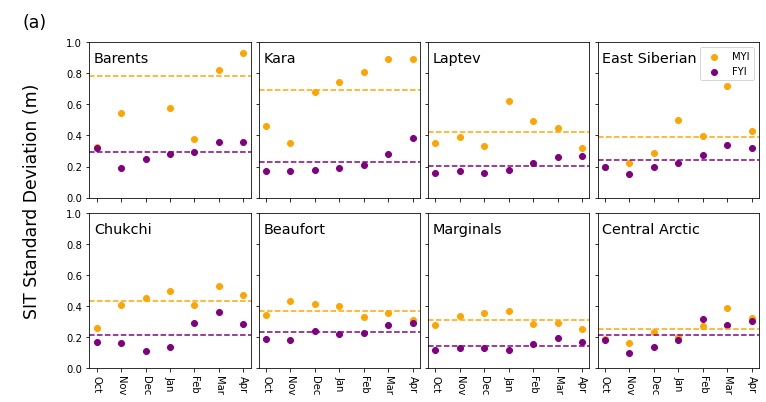

In [30]:
fig = plt.figure(figsize=(12,6))

for subplot_counter, key in enumerate(region_list, 1):
    
    ax = plt.subplot(2,4,subplot_counter)
    
    MYI_region_data = MYI_trends_dict[key]
    FYI_region_data = FYI_trends_dict[key]


    SM_trends, W99_trends = [], []
    
    for month in rea(month_list):
        
        SM_trends.append(MYI_region_data[month][2])
        W99_trends.append(FYI_region_data[month][2])
        
    W99_ave = np.nanmean(W99_trends)
    SM_ave = np.nanmean(SM_trends)
    
    ax.axhline(SM_ave,color='orange',linestyle='--')
    
    ax.axhline(W99_ave,color='purple',linestyle='--')
    
    print(f'region:{key}, W99:{W99_ave}, SM:{SM_ave}, %inc: {(SM_ave-W99_ave)/W99_ave}')
    
    ax.scatter(month_name_list_full,SM_trends,label='MYI',color='orange')
    
    ax.scatter(month_name_list_full,W99_trends,label='FYI',color='purple')
    
    if key == 'East Siberian':
        print(SM_trends)
    
    # Legend
    
    if subplot_counter == 4:
        ax.legend(loc='upper right')
        
    ax.annotate(key,
                  xy = (0.03,0.87),xycoords='axes fraction',
                  ha='left',fontsize="x-large",color='k')
    
    ax.set_ylim(0,1)
    
    if subplot_counter in [2,3,4,6,7,8]:
        ax.set_yticklabels([])
    
    if subplot_counter in [1,2,3,4]:
        ax.set_xticks(ticks=month_name_list_full)
        ax.set_xticklabels([])
    else:
        ax.set_xticks(ticks=month_name_list_full)
        ax.set_xticklabels(month_name_list_short,rotation = 270)

    

    
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.annotate("SIT Standard Deviation (m)",
                 xy = (0.03,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

plt.annotate("(a)",
                 xy = (0.03,0.93),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='left')

a_var_fig_name="ice_type_rel_variability_abs.png"
plt.savefig(a_var_fig_name,dpi=600,bbox_inches='tight')

plt.show()



region:Barents, W99:14.31658793630019, SM:48.61324897645208, %inc: 34.29666104015189
region:Kara, W99:9.958435887534808, SM:41.23167240493957, %inc: 31.273236517404765
region:Laptev, W99:10.291180945653979, SM:28.447070742323376, %inc: 18.1558897966694
region:East Siberian, W99:10.807118123808465, SM:24.20099386749404, %inc: 13.393875743685577
[21.96416038 16.5946862  19.13763192 32.95489097 22.79534545 35.55525538
 20.40498677]
region:Chukchi, W99:7.9136126974356085, SM:33.27062647135212, %inc: 25.357013773916506
region:Beaufort, W99:9.853702829224003, SM:25.26740414883624, %inc: 15.413701319612235
SM_std: 21.671737987328022, W99_std: 6.188042730961835
region:Marginals, W99:6.188042730961835, SM:21.671737987328022, %inc: 15.483695256366186
region:Central Arctic, W99:8.935871270243814, SM:10.47299176176198, %inc: 1.5371204915181664


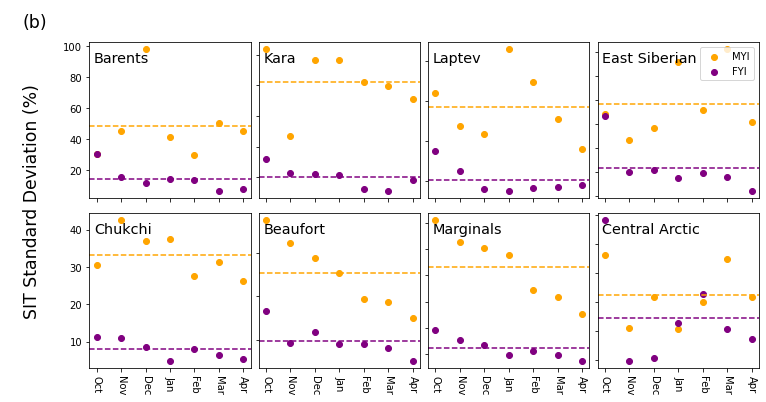

In [31]:
fig = plt.figure(figsize=(12,6))

for subplot_counter, key in enumerate(region_list, 1):
    
    ax = plt.subplot(2,4,subplot_counter)
    
    MYI_region_data = MYI_trends_dict[key]
    FYI_region_data = FYI_trends_dict[key]


    SM_trends, W99_trends = [], []
    SM_means, W99_means = [], []
    
    for month in rea(month_list):
        
        SM_trends.append(MYI_region_data[month][2])
        SM_means.append(MYI_region_data[month][-2])
        W99_trends.append(FYI_region_data[month][3])
        W99_means.append(FYI_region_data[month][-1])
        
    SM_trends = np.divide(SM_trends,SM_means)*100
    W99_trends = np.divide(W99_trends,W99_means)*100
    
    W99_ave = np.nanmean(W99_trends)
    SM_ave = np.nanmean(SM_trends)
    
    if key == 'Marginals':
        print(f'SM_std: {SM_ave}, W99_std: {W99_ave}')
    
    ax.axhline(SM_ave,color='orange',linestyle='--')
    
    ax.axhline(W99_ave,color='purple',linestyle='--')
    
    print(f'region:{key}, W99:{W99_ave}, SM:{SM_ave}, %inc: {(SM_ave-W99_ave)}')
    
    ax.scatter(month_name_list_full,SM_trends,label='MYI',color='orange')
    
    ax.scatter(month_name_list_full,W99_trends,label='FYI',color='purple')
    
    if key == 'East Siberian':
        print(SM_trends)
    
    # Legend
    
    if subplot_counter == 4:
        ax.legend(loc='upper right')
        
    ax.annotate(key,
                  xy = (0.03,0.87),xycoords='axes fraction',
                  ha='left',fontsize="x-large",color='k')
    
#     ax.set_ylim(0,40)
    
    if subplot_counter in [2,3,4,6,7,8]:
        ax.set_yticklabels([])
    
    if subplot_counter in [1,2,3,4]:
        ax.set_xticks(ticks=month_name_list_full)
        ax.set_xticklabels([])
    else:
        ax.set_xticks(ticks=month_name_list_full)
        ax.set_xticklabels(month_name_list_short,rotation = 270)
        

    
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.annotate("SIT Standard Deviation (%)",
                 xy = (0.03,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

plt.annotate("(b)",
                 xy = (0.03,0.93),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='left')

b_var_fig_name="ice_type_rel_variability_rel.png"
plt.savefig(b_var_fig_name,dpi=600,bbox_inches='tight')

plt.show()

dir_to_combine = f'{dir_to_save}/Sup_Figs/'
str_to_pass = f'convert {a_var_fig_name} {b_var_fig_name} -append {dir_to_combine}ice_type_variabilities.png'
!{str_to_pass}

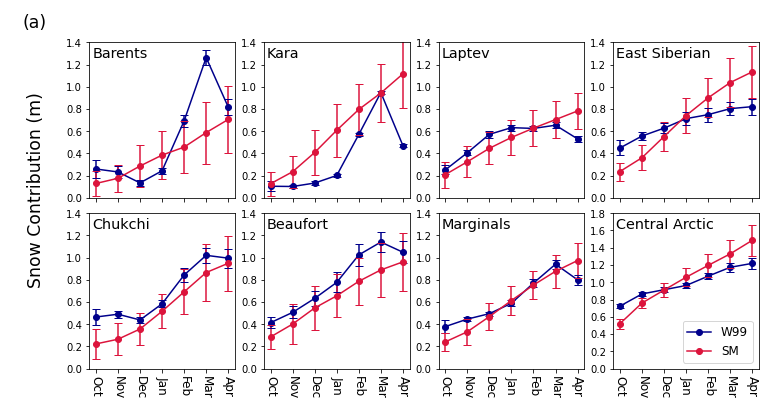

In [59]:
seasonal = beta.groupby([beta.region, beta.month]).mean()
seasonal_std = beta.groupby([beta.region, beta.month]).std() 

_avefig = plt.figure(figsize=(12,6))

for subplot_counter, region in enumerate(region_list,1):
    
    ax = plt.subplot(2,4,subplot_counter)
    
    W99_seasonal_ave = seasonal['all mW99 contribution'][region]
    SM_seasonal_ave = seasonal['all SM contribution'][region]
    
    
    W99_seasonal_std = seasonal_std['all mW99 contribution'][region]
    SM_seasonal_std = seasonal_std['all SM contribution'][region]

    
    ax.plot(rea(W99_seasonal_ave.keys()),
             rea(W99_seasonal_ave),
             color='darkblue',
             marker='o',
             label = 'W99')
    
    ax.errorbar(rea(W99_seasonal_ave.keys()),
                 rea(W99_seasonal_ave),
                 yerr=rea(W99_seasonal_std),
                 ecolor='darkblue',
                 ls='none',
                 capsize=4)
    
    ##############################################
    
    ax.plot(rea(SM_seasonal_ave.keys()),
             rea(SM_seasonal_ave),
             marker='o',
             color='crimson',
             label = 'SM')
    
    ax.errorbar(rea(SM_seasonal_ave.keys()),
                 rea(SM_seasonal_ave),
                 yerr=rea(SM_seasonal_std),
                 ecolor='crimson',
                 ls='none',
                 capsize=4)
    
    ax.annotate(region,xy = (0.02,0.9),xycoords='axes fraction',fontsize='x-large')

    ax.set_ylim(0,1.8) if region == 'Central Arctic' else ax.set_ylim(0,1.4)
    
    if region == 'Central Arctic': ax.set_yticks(np.arange(0,1.81,0.2)) 
    
    if subplot_counter <= 4:
        ax.set_xticks(ticks=rea(SM_seasonal_ave.keys()))
        ax.set_xticklabels([])
    else:
        ax.set_xticks(ticks=rea(SM_seasonal_ave.keys()))
        ax.set_xticklabels(month_name_list_short,rotation=270,fontsize='large')

    
    if subplot_counter == 8:
        plt.legend(fontsize='large',loc='lower right')
    
plt.subplots_adjust(wspace=0.2, hspace=0.1)

plt.annotate("Snow Contribution (m)",
             xy = (0.035,0.3),
             xycoords="figure fraction",
             rotation=90,
             fontsize="xx-large")

plt.annotate("(a)",
                 xy = (0.03,0.93),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='left')

plt.savefig(f"{dir_to_save}/Sup_Figs/seasonal_snow_contrib.png",
            dpi=450, bbox_inches='tight')
plt.show()




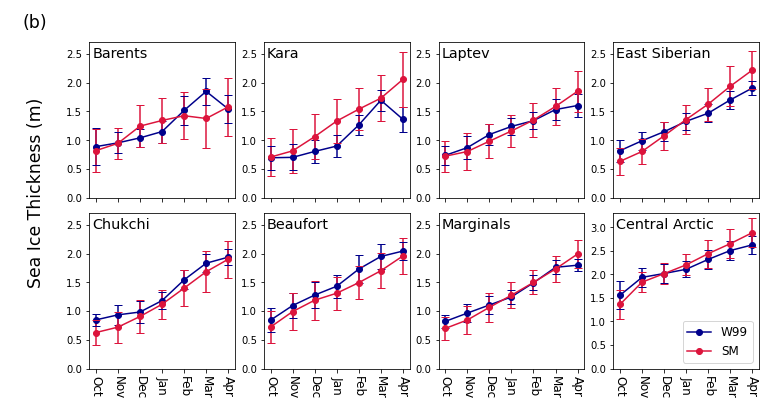

In [60]:
fig = plt.figure(figsize=(12,6))

for subplot_counter, region in enumerate(region_list,1):
    
    ax = plt.subplot(2,4,subplot_counter)
    
    W99_seasonal_ave = seasonal['all mW99 thickness'][region]
    SM_seasonal_ave = seasonal['all SM thickness'][region]
    
    
    W99_seasonal_std = seasonal_std['all mW99 thickness'][region]
    SM_seasonal_std = seasonal_std['all SM thickness'][region]

    
    ax.plot(rea(W99_seasonal_ave.keys()),
             rea(W99_seasonal_ave),
             color='darkblue',
             marker='o',
             label = 'W99')
    
    ax.errorbar(rea(W99_seasonal_ave.keys()),
                 rea(W99_seasonal_ave),
                 yerr=rea(W99_seasonal_std),
                 ecolor='darkblue',
                 ls='none',
                 capsize=4)
    
    ##############################################
    
    ax.plot(rea(SM_seasonal_ave.keys()),
             rea(SM_seasonal_ave),
             marker='o',
             color='crimson',
             label = 'SM')
    
    ax.errorbar(rea(SM_seasonal_ave.keys()),
                 rea(SM_seasonal_ave),
                 yerr=rea(SM_seasonal_std),
                 ecolor='crimson',
                 ls='none',
                 capsize=4)
    
    ax.annotate(region,xy = (0.02,0.9),xycoords='axes fraction',fontsize='x-large')

    
    if subplot_counter <= 4:
        ax.set_xticks(ticks=rea(SM_seasonal_ave.keys()))
        ax.set_xticklabels([])
    else:
        ax.set_xticks(ticks=rea(SM_seasonal_ave.keys()))
        ax.set_xticklabels(month_name_list_short,rotation=270,fontsize='large')
    
    if region in ['Central Arctic']:
        ax.set_ylim(0,3.3)
    else:
        ax.set_ylim(0,2.7)
    
    if subplot_counter == 8:
        ax.legend(fontsize='large',loc='lower right')
    
plt.subplots_adjust(wspace=0.2, hspace=0.1)

plt.annotate("Sea Ice Thickness (m)",
             xy = (0.035,0.3),
             xycoords="figure fraction",
             rotation=90,
             fontsize="xx-large")

plt.annotate("(b)",
                 xy = (0.03,0.93),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='left')

plt.savefig(f"{dir_to_save}/Sup_Figs/seasonal_SIT_contrib.png",
            dpi=450, bbox_inches='tight')
plt.show()

str_to_pass = f'convert {dir_to_save}/Sup_Figs/seasonal_snow_contrib.png {dir_to_save}/Sup_Figs/seasonal_SIT_contrib.png -append {dir_to_save}/Sup_Figs/seasonal_composite.png'
!{str_to_pass}



# Check trends are the same for E5 & M2

all
Region: Barents, Month: 11, SM: -0.032, mW: -0.033
Region: Barents, Month: 12, SM: -0.049, mW: -0.051
Region: Barents, Month: 01, SM: -0.052, mW: -0.055
Region: Barents, Month: 02, SM: -0.053, mW: -0.06
Region: Barents, Month: 03, SM: -0.071, mW: -0.077
Region: Barents, Month: 04, SM: -0.064, mW: -0.071
Region: Kara, Month: 10, SM: -0.057, mW: -0.055
Region: Kara, Month: 11, SM: -0.072, mW: -0.07
Region: Kara, Month: 12, SM: -0.074, mW: -0.071
Region: Kara, Month: 01, SM: -0.069, mW: -0.069
Region: Kara, Month: 02, SM: -0.059, mW: -0.064
Region: Kara, Month: 03, SM: -0.057, mW: -0.065
Region: Kara, Month: 04, SM: -0.06, mW: -0.069
Region: Laptev, Month: 10, SM: -0.042, mW: -0.04
Region: Laptev, Month: 11, SM: -0.05, mW: -0.052
Region: Laptev, Month: 12, SM: -0.045, mW: -0.049
Region: Laptev, Month: 01, SM: -0.039, mW: -0.046
Region: Laptev, Month: 02, SM: -0.035, mW: -0.044
Region: Laptev, Month: 04, SM: -0.04, mW: -0.053
Region: East Siberian, Month: 11, SM: -0.023, mW: -0.028
Reg

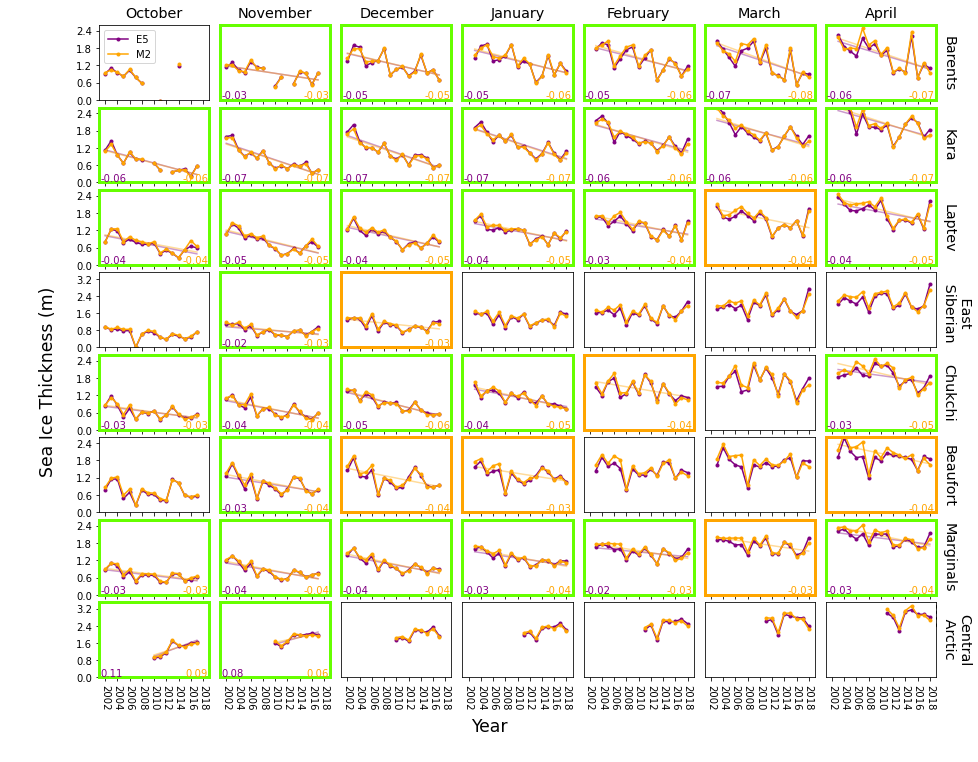

In [39]:
def timeseries(snow_product_1, snow_product_2):
    
    ice_type = 'all'
    col1 = 'purple'; col2 = 'orange'
    
    significance_increase = []
    
    trends_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    
    print(ice_type)

    fig = plt.figure(figsize=(15,12))
    
    for subplot_counter, (region, month) in enumerate(itertools.product(region_list,rea(month_list)),1):

        ax = plt.subplot(len(region_list),len(month_list),subplot_counter)

        SM_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        

        SM1 = list(SM_subset[f'{ice_type} {snow_product_1} thickness'])
        SM2 = list(SM_subset[f'{ice_type} {snow_product_2} thickness'])

        yearlist = list(SM_subset['year'])

        # Calculate statistics
        SM1_stats = nanregress(yearlist,SM1)
        SM1_mean = np.nanmean(SM1)

        SM2_stats = nanregress(yearlist,SM2)
        SM2_mean = np.nanmean(SM2)
        
        if (SM1_stats[3] < 0.05) and (SM2_stats[3] < 0.05):

            # Shade if SM & W99 -> Green Solid Outline

            for spine in ax.spines.values():
                spine.set_edgecolor('#66ff00')
                spine.set_linewidth('3')
                
            ax.plot(yearlist, np.array(yearlist)*SM1_stats[0] + SM1_stats[1], color=col1, alpha=0.4)
            ax.plot(yearlist, np.array(yearlist)*SM2_stats[0] + SM2_stats[1], color=col2, alpha=0.4)
   
            ax.annotate(np.round(SM1_stats[0], decimals = 2), xy = (0.01,0.02),
                        xycoords = 'axes fraction',color=col1)
            ax.annotate(np.round(SM2_stats[0], decimals = 2), xy = (0.99,0.02),
                        xycoords = 'axes fraction',color=col2, ha='right')
        
            
            print(f'Region: {region}, Month: {month}, SM: {np.round(SM1_stats[0], decimals = 3)}, mW: {np.round(SM2_stats[0], decimals = 3)}')
            



        elif (SM1_stats[3] < 0.05):
            
            ax.plot(yearlist, np.array(yearlist)*SM1_stats[0] + SM1_stats[1], color=col1, alpha=0.4)

            # If only SM significant -> Crimson Solid outline
            
            ax.annotate(np.round(SM1_stats[0], decimals = 2), xy = (0.01,0.02),
                        xycoords = 'axes fraction',color=col1)


            for spine in ax.spines.values():
                spine.set_edgecolor(col1)
                spine.set_linewidth('3')

        elif (SM2_stats[3] < 0.05):
            
            ax.plot(yearlist, np.array(yearlist)*SM2_stats[0] + SM2_stats[1], color=col2, alpha=0.4)
            ax.annotate(np.round(SM2_stats[0], decimals = 2), xy = (0.99,0.02),
                        xycoords = 'axes fraction',color=col2, ha='right')


            # If only W99 significant -> Darkblue Solid outline

            for spine in ax.spines.values():
                spine.set_edgecolor(col2)
                spine.set_linewidth('3')

        ax.plot(yearlist,SM1,
                      marker='.',label=snow_product_1,color=col1)

        ax.plot(yearlist,SM2,
                      marker='.',label=snow_product_2,color=col2)





        # Set appropriate y axis limits

        if region in ["Central Arctic",  "East Siberian"]:
            ax.set_ylim(0,3.5)
        else:
            ax.set_ylim(0,2.6)


        # Make month name annotations

        if subplot_counter <= len(month_list):

            ax.annotate(month_name_list_full[subplot_counter-1],
                              xy = (0.5,1.1),xycoords='axes fraction',
                              fontsize="x-large",ha='center')


        # Make region name annotations

        if subplot_counter% 7 == 0:
            
            if region == 'Central Arctic':
                region_name = 'Central\n Arctic'
            elif region == 'East Siberian':
                region_name = '    East\n Siberian'
            else:
                region_name = region
            
            ax.annotate(region_name,xy = (1.05,0.5),
                              xycoords='axes fraction',
                              fontsize='x-large',
                              va='center',
                              ha='left',
                              rotation=270)

        # Make y ticks depending on ylims

        if region in ["Central Arctic",  "East Siberian"]:
            yticks = np.linspace(0,3.2,5)
            yticks = np.around(yticks,decimals=2)
        else:
            yticks = np.linspace(0,2.4,5)
            yticks = np.around(yticks,decimals=2)

        if subplot_counter % 7 == 1:

            ax.set_yticks(ticks=yticks)
            ax.set_yticklabels(yticks)
        else:
            ax.set_yticks(ticks=[])

        # Make x ticks
        
        xticks = range(2002,2019,2)
        ax.set_xlim(2001,2019)

        
        if subplot_counter < len(month_list)*(len(region_list)-1):
            ax.set_xticks(ticks=xticks)
            ax.set_xticklabels([])
        else:
            ax.set_xticks(xticks)
            ax.tick_params('x',rotation = 270)
            
        # Annotate trends
         

        # Make legend

        if subplot_counter == 1:
            plt.legend(fontsize='medium',loc='upper left')


    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.annotate("Sea Ice Thickness (m)",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

    plt.annotate("Year",
                 xy = (0.5,0.04),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')
    
    
    fig.savefig(f"{dir_to_save}/Sup_Figs/reanalysis_trends_comparison.png",
                dpi=450, bbox_inches='tight')

    
    plt.show()
    
    
timeseries('E5','M2')

all
Region: Barents, Month: 11, SM: -0.015, mW: -0.016 Frac: -64.424
Region: Barents, Month: 12, SM: -0.022, mW: -0.023 Frac: -43.265
Region: Barents, Month: 01, SM: -0.027, mW: -0.03 Frac: -33.221
Region: Barents, Month: 02, SM: -0.031, mW: -0.035 Frac: -28.794
Region: Kara, Month: 10, SM: -0.013, mW: -0.012 Frac: -80.113
Region: Kara, Month: 11, SM: -0.021, mW: -0.019 Frac: -51.626
Region: Kara, Month: 12, SM: -0.031, mW: -0.028 Frac: -35.455
Region: Kara, Month: 01, SM: -0.034, mW: -0.035 Frac: -28.664
Region: Kara, Month: 02, SM: -0.027, mW: -0.033 Frac: -30.586
Region: Laptev, Month: 11, SM: -0.015, mW: -0.017 Frac: -57.876
Region: Laptev, Month: 12, SM: -0.017, mW: -0.021 Frac: -47.873
Region: Laptev, Month: 01, SM: -0.018, mW: -0.025 Frac: -40.064
Region: Chukchi, Month: 12, SM: -0.016, mW: -0.02 Frac: -49.924
Region: Marginals, Month: 12, SM: -0.014, mW: -0.019 Frac: -53.137
Region: Marginals, Month: 01, SM: -0.014, mW: -0.022 Frac: -44.6


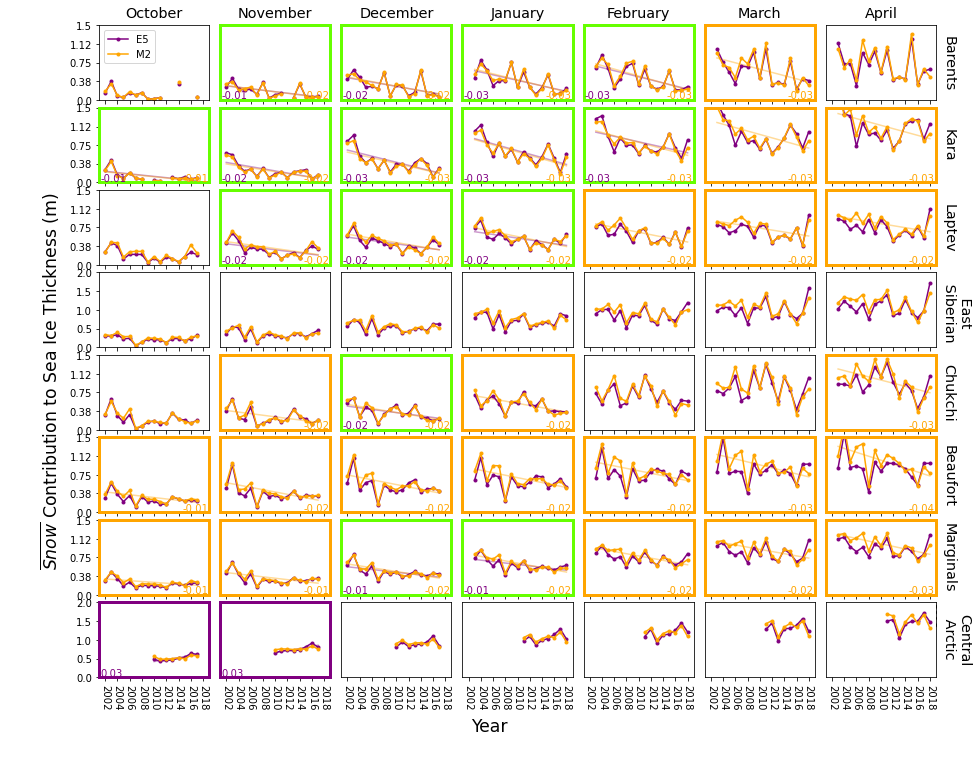

In [40]:
def timeseries(snow_product_1, snow_product_2):
    
    ice_type = 'all'
    col1 = 'purple'; col2 = 'orange'
    
    significance_increase = []
    
    trends_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    
    print(ice_type)

    fig = plt.figure(figsize=(15,12))
    
    for subplot_counter, (region, month) in enumerate(itertools.product(region_list,rea(month_list)),1):

        ax = plt.subplot(len(region_list),len(month_list),subplot_counter)

        SM_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        

        SM1 = list(SM_subset[f'{ice_type} {snow_product_1} contribution'])
        SM2 = list(SM_subset[f'{ice_type} {snow_product_2} contribution'])

        yearlist = list(SM_subset['year'])

        # Calculate statistics
        SM1_stats = nanregress(yearlist,SM1)
        SM1_mean = np.nanmean(SM1)

        SM2_stats = nanregress(yearlist,SM2)
        SM2_mean = np.nanmean(SM2)
        
        if (SM1_stats[3] < 0.05) and (SM2_stats[3] < 0.05):

            # Shade if SM & W99 -> Green Solid Outline

            for spine in ax.spines.values():
                spine.set_edgecolor('#66ff00')
                spine.set_linewidth('3')
                
            ax.plot(yearlist, np.array(yearlist)*SM1_stats[0] + SM1_stats[1], color=col1, alpha=0.4)
            ax.plot(yearlist, np.array(yearlist)*SM2_stats[0] + SM2_stats[1], color=col2, alpha=0.4)
   
            ax.annotate(np.round(SM1_stats[0], decimals = 2), xy = (0.01,0.02),
                        xycoords = 'axes fraction',color=col1)
            ax.annotate(np.round(SM2_stats[0], decimals = 2), xy = (0.99,0.02),
                        xycoords = 'axes fraction',color=col2, ha='right')
        
            
            print(f'Region: {region}, Month: {month}, SM: {np.round(SM1_stats[0], decimals = 3)}, mW: {np.round(SM2_stats[0], decimals = 3)} Frac: {np.round((SM1_stats[0]/SM2_stats[0])/SM1_stats[0], decimals = 3)}')
            



        elif (SM1_stats[3] < 0.05):
            
            ax.plot(yearlist, np.array(yearlist)*SM1_stats[0] + SM1_stats[1], color=col1, alpha=0.4)

            # If only SM significant -> Crimson Solid outline
            
            ax.annotate(np.round(SM1_stats[0], decimals = 2), xy = (0.01,0.02),
                        xycoords = 'axes fraction',color=col1)


            for spine in ax.spines.values():
                spine.set_edgecolor(col1)
                spine.set_linewidth('3')

        elif (SM2_stats[3] < 0.05):
            
            ax.plot(yearlist, np.array(yearlist)*SM2_stats[0] + SM2_stats[1], color=col2, alpha=0.4)
            ax.annotate(np.round(SM2_stats[0], decimals = 2), xy = (0.99,0.02),
                        xycoords = 'axes fraction',color=col2, ha='right')


            # If only W99 significant -> Darkblue Solid outline

            for spine in ax.spines.values():
                spine.set_edgecolor(col2)
                spine.set_linewidth('3')

        ax.plot(yearlist,SM1,
                      marker='.',label=snow_product_1,color=col1)

        ax.plot(yearlist,SM2,
                      marker='.',label=snow_product_2,color=col2)





        # Set appropriate y axis limits




        # Make month name annotations

        if subplot_counter <= len(month_list):

            ax.annotate(month_name_list_full[subplot_counter-1],
                              xy = (0.5,1.1),xycoords='axes fraction',
                              fontsize="x-large",ha='center')


        # Make region name annotations

        if subplot_counter% 7 == 0:
            
            if region == 'Central Arctic':
                region_name = 'Central\n Arctic'
            elif region == 'East Siberian':
                region_name = '    East\n Siberian'
            else:
                region_name = region
            
            ax.annotate(region_name,xy = (1.05,0.5),
                              xycoords='axes fraction',
                              fontsize='x-large',
                              va='center',
                              ha='left',
                              rotation=270)

#         Make y ticks depending on ylims


        
        if region in ['Central Arctic', 'East Siberian']:
            
            ax.set_ylim(0,2)
            yticks = np.linspace(0,2,5)
        
        else:
            
            yticks = np.linspace(0,1.5,5)
            ax.set_ylim(0,1.5)

        
        yticks = np.around(yticks,decimals=2)

        if subplot_counter % 7 == 1:

            ax.set_yticks(ticks=yticks)
            ax.set_yticklabels(yticks)
        else:
            ax.set_yticks(ticks=[])

        # Make x ticks
        
        xticks = range(2002,2019,2)
        ax.set_xlim(2001,2019)

        
        if subplot_counter < len(month_list)*(len(region_list)-1):
            ax.set_xticks(ticks=xticks)
            ax.set_xticklabels([])
        else:
            ax.set_xticks(xticks)
            ax.tick_params('x',rotation = 270)
            
        # Annotate trends
         

        # Make legend

        if subplot_counter == 1:
            plt.legend(fontsize='medium',loc='upper left')


    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.annotate(r"$\overline{Snow}$ Contribution to Sea Ice Thickness (m)",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

    plt.annotate("Year",
                 xy = (0.5,0.04),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')
    
    
    fig.savefig(f"{dir_to_save}/Sup_Figs/reanalysis_trends_comparison_snow.png",
                dpi=450, bbox_inches='tight')

    
    plt.show()
    
    
timeseries('E5','M2')

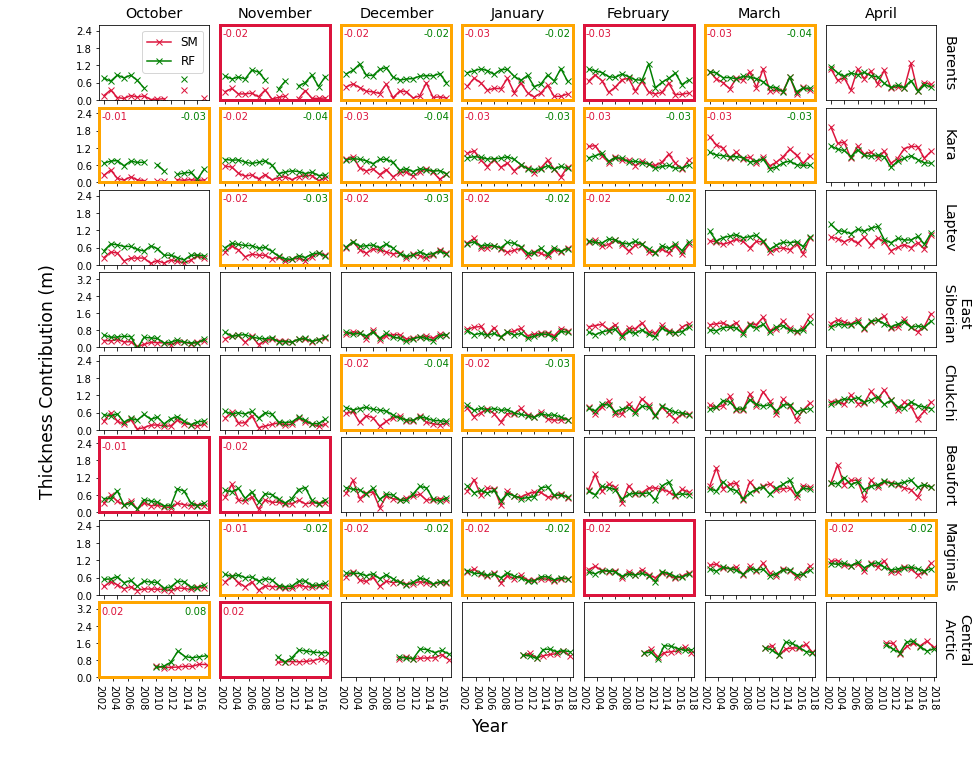

In [41]:
def timeseries(ice_type, beta, printer=False):
    
    trends_dict = {}

    fig = plt.figure(figsize=(15,12))
    
    subplot_counter = 1
    
    total_subplots = len(region_list) * len(month_list)

    for region in region_list:

        trends_dict[region] = {}
        
        for month in rea(month_list):

            if int(month) < 5:
                yearlist = list(range(2003,2019))
            elif int(month) > 7:
                yearlist = list(range(2002,2018))

            ax = plt.subplot(len(region_list),len(month_list),subplot_counter)
            
            W99_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
            W99 = list(W99_subset[f'{ice_type} free contribution'])
            
            SM_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
            SM = list(SM_subset[f'{ice_type} SM contribution'])
            
            yearlist = list(SM_subset['year'])
    
            
            # Deal with the trunkated Central Arctic series

            if region == 'Central Arctic':
                SM = np.array(    list(np.full(8,np.nan)) + list(SM)  )
                W99 = np.array(   list(np.full(8,np.nan)) + list(W99) )
                
                yearlist = np.array(   list(range(2002,2010)) + list(yearlist) )
                
                
                CA_flag = True

            # Calculate statistics

            SM_slope = nanregress(yearlist,SM)
            W99_slope = nanregress(yearlist,W99)
            
            if printer: print(f'{region}{month}_{np.round(SM_slope[0],decimals=2)}')

            a = SM_slope[3] < 0.05
            b = W99_slope[3] < 0.05

            if a:

                if a and b:
                    
                    trends_dict[region][month] = (SM_slope[0],W99_slope[0])
                    
                    plt.annotate(np.round(SM_slope[0], decimals = 2), xy = (0.02,0.95),
                        xycoords = 'axes fraction',color='crimson', ha='left',va='top')
                    plt.annotate(np.round(W99_slope[0], decimals = 2), xy = (0.98,0.95),
                        xycoords = 'axes fraction',color='green', ha='right',va='top')

                    # Shade if SM & W99 statistically significant slope

                    for spine in ax.spines.values():
                        spine.set_edgecolor('orange')
                        spine.set_linewidth('3')

                elif a:
                    
                    trends_dict[region][month] = (SM_slope[0],np.nan)

                    # Shade if only SM statistically significant slope
                    
                    plt.annotate(np.round(SM_slope[0], decimals = 2), xy = (0.02,0.95),
                        xycoords = 'axes fraction',color='crimson', ha='left',va='top')
                    
                    for spine in ax.spines.values():
                        spine.set_edgecolor('crimson')
                        spine.set_linewidth('3')
                        
                elif b:
                    
                    trends_dict[region][month] = (W99_slope[0],np.nan)

                    # Shade if only SM statistically significant slope
                    
                    plt.annotate(np.round(W99_slope[0], decimals = 2), xy = (0.98,0.95),
                        xycoords = 'axes fraction',color='green', ha='right',va='top')
                    
                    for spine in ax.spines.values():
                        spine.set_edgecolor('green')
                        spine.set_linewidth('3')
                    
            else:
        
                trends_dict[region][month] = (np.nan,np.nan)
                


            # Make the two line plots


            ax = plt.plot(yearlist,SM,
                          marker='x',label='SM',color='crimson')

            ax = plt.plot(yearlist,W99,
                          marker='x',label='RF',color='green')





            # Set appropriate y axis limits

            if region in ["Central Arctic",  "East Siberian"]:
                ax = plt.ylim(0,3.5)
            else:
                ax = plt.ylim(0,2.6)


            # Make month name annotations

            if subplot_counter < 8:

                ax = plt.annotate(month_name_list_full[subplot_counter-1],
                                  xy = (0.5,1.1),xycoords='axes fraction',
                                  fontsize="x-large",ha='center')

            # Make region name annotations

            if subplot_counter% 7 == 0:

                if region == 'Central Arctic':
                    region_name = 'Central\n Arctic'
                elif region == 'East Siberian':
                    region_name = '    East\n Siberian'
                else:
                    region_name = region

                ax = plt.annotate(region_name,xy = (1.05,0.5),
                                  xycoords='axes fraction',
                                  fontsize='x-large',
                                  va='center',
                                  ha='left',
                                  rotation=270)

            # Make y ticks depending on ylims

            if region in ["Central Arctic",  "East Siberian"]:
                yticks = np.linspace(0,3.2,5)
                yticks = np.around(yticks,decimals=2)
            else:
                yticks = np.linspace(0,2.4,5)
                yticks = np.around(yticks,decimals=2)

            if (subplot_counter-1) %7 == 0:

                plt.yticks(ticks=yticks,labels=yticks)
            else:
                plt.yticks(ticks=[])

            # Make x ticks

            if subplot_counter < total_subplots-7:
                plt.xticks(ticks=list(range(yearlist[0],yearlist[-1],2)),labels=[])
            else:

                plt.xticks(np.arange(yearlist[0], yearlist[-1]+1, 2),rotation = 270)

            # Make legend

            if subplot_counter == 1:
                plt.legend(fontsize='large',loc='upper right')
                
                
            subplot_counter +=1

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.annotate("Thickness Contribution (m)",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

    plt.annotate("Year",
                 xy = (0.5,0.04),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')
    
    fig.savefig(f"{dir_to_save}/Sup_Figs/fb_vs_sm_contributions.png",
                dpi=450, bbox_inches='tight')
    
    plt.show()
    
timeseries('all', beta)   
# timeseries('all', beta_adj)

all


/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib

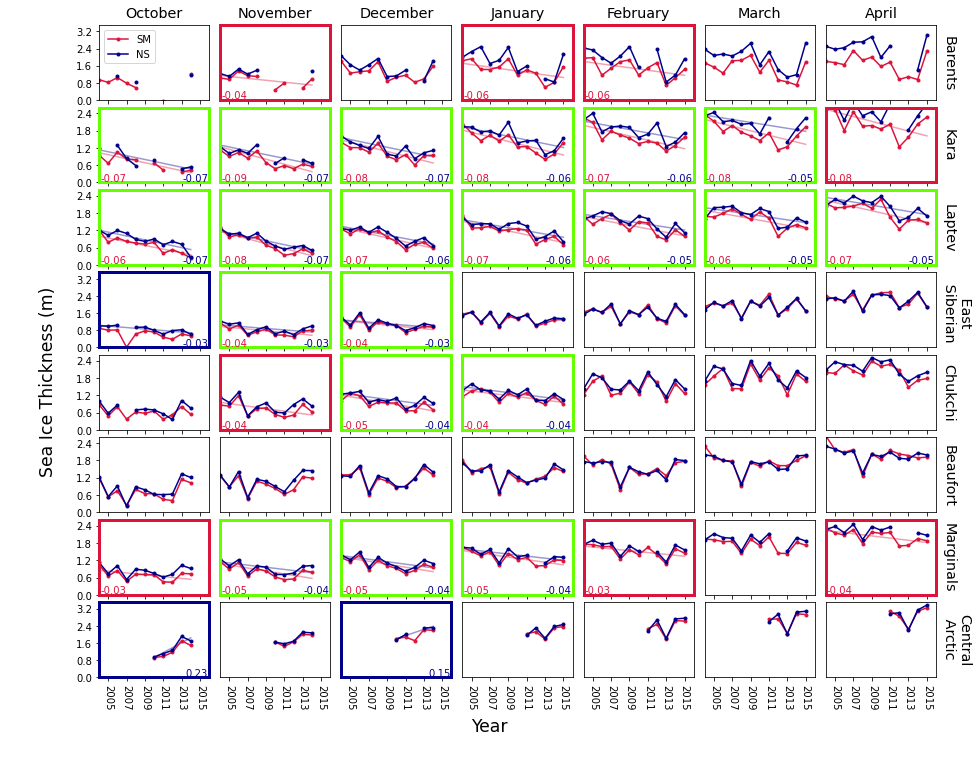

In [39]:
all_trends_dict = timeseries('all','SM','NS', beta, print_statistics=False)


FYI


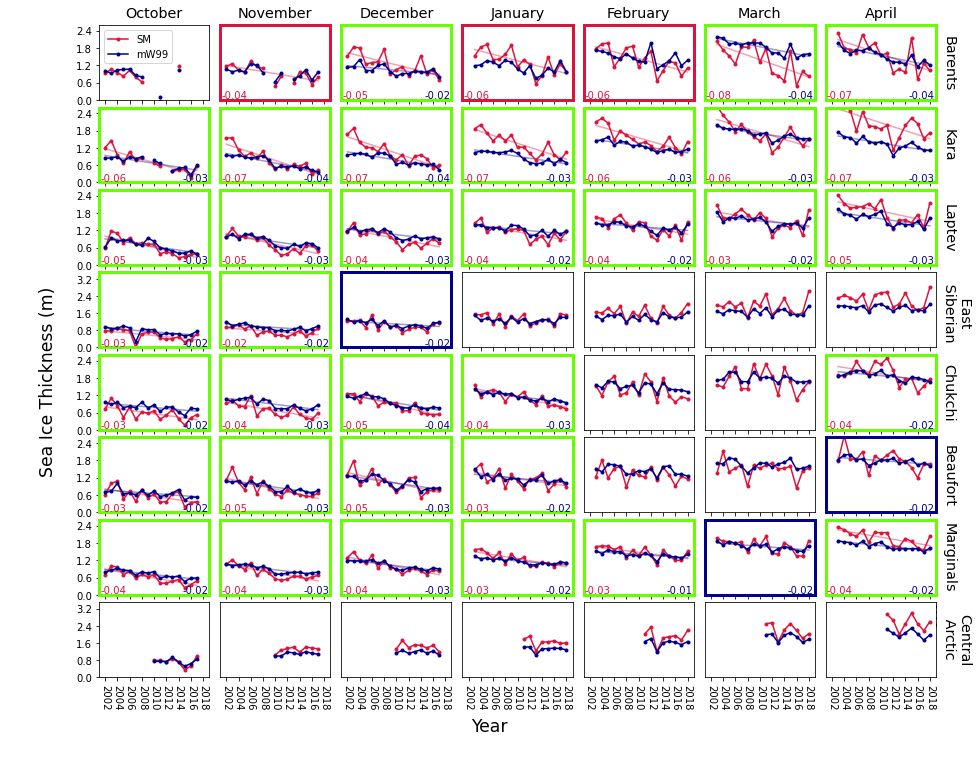

defaultdict(<function __main__.timeseries.<locals>.<lambda>()>,
            {'Barents': defaultdict(<function __main__.timeseries.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'10': (nan,
                           nan,
                           0.31975405480670427,
                           0.2636948586843868,
                           0.8163667204204889,
                           0.8763064924704715),
                          '11': (-0.03553059546398995,
                           nan,
                           0.19165097507516676,
                           0.15036133652751799,
                           0.9381519676482128,
                           0.9500877955788248),
                          '12': (-0.05303331665241882,
                           -0.020090626409160022,
                           0.2479244821013422,
                           0.12111789140195926,
                           1.2442253884619574,
                           1.0414378864133835

In [36]:
timeseries('FYI','SM','mW99', beta, print_statistics=False)


MYI


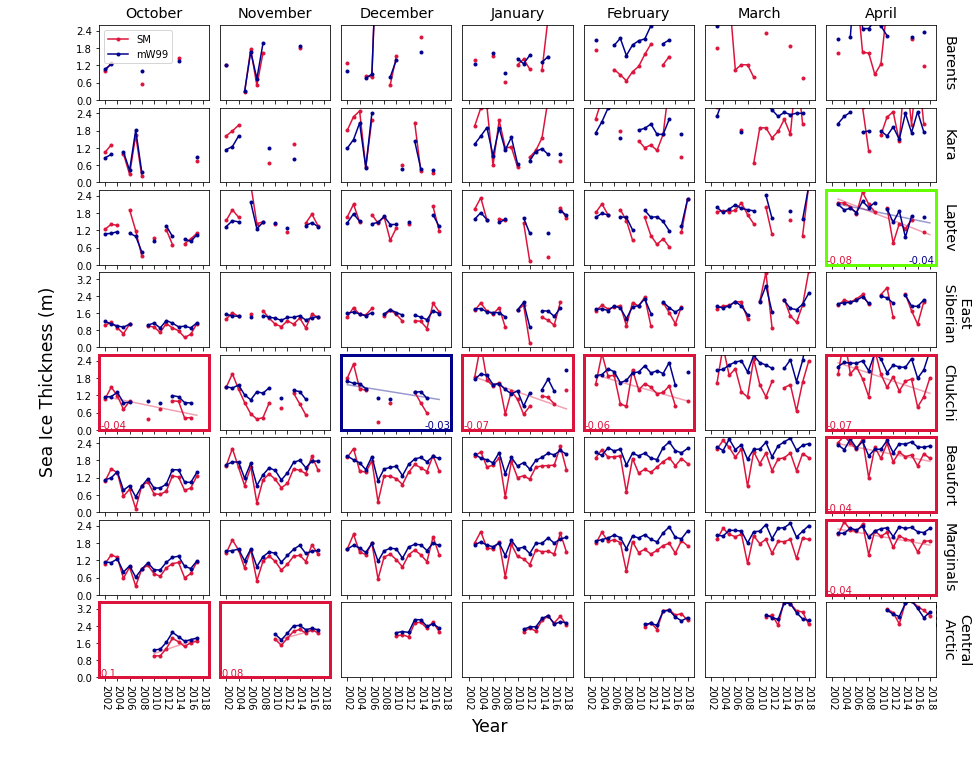

defaultdict(<function __main__.timeseries.<locals>.<lambda>()>,
            {'Barents': defaultdict(<function __main__.timeseries.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'10': (nan,
                           nan,
                           0.32803291889198993,
                           0.11354009059077542,
                           1.0735051088731224,
                           1.1716347850614963),
                          '11': (nan,
                           nan,
                           0.5439168002757219,
                           0.5265645446283583,
                           1.196457027121032,
                           1.2934368866606716),
                          '12': (nan,
                           nan,
                           1.9013655042823916,
                           1.8865729909600044,
                           1.943123317879549,
                           1.84846640314923),
                          '01': (nan,
                 

In [37]:
timeseries('MYI','SM','mW99', beta, print_statistics=False)
